In [32]:
# %% [markdown]
"""
# Prétraitement EEG - Pipeline Complet

Ce notebook implémente un pipeline complet de prétraitement EEG pour les données du projet fédéral.

## Objectifs :
- Chargement des données EEG brutes
- Application d'un pipeline de prétraitement robuste
- Contrôle qualité automatique
- Extraction des features
- Sauvegarde des données nettoyées
"""

# %%
# ÉTAPE 1: Importation des bibliothèques
print("🔄 ÉTAPE 1: Importation des bibliothèques...")

import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json
import warnings
warnings.filterwarnings('ignore')

# Import MNE pour le traitement EEG
try:
    import mne
    from mne import io
    from mne.preprocessing import ICA
    print("✓ MNE importé avec succès")
except ImportError as e:
    print(f"❌ Erreur import MNE: {e}")
    sys.exit(1)


🔄 ÉTAPE 1: Importation des bibliothèques...
✓ MNE importé avec succès


In [33]:

# %%
# ÉTAPE 2: Configuration du projet
print("\n🔄 ÉTAPE 2: Configuration du projet...")

# Configuration des chemins
project_root = Path.cwd().parent.parent
raw_eeg_path = project_root / 'data' / 'raw' / 'eeg'
processed_eeg_path = project_root / 'data' / 'processed' / 'eeg'

# Créer les dossiers de sortie
processed_eeg_path.mkdir(parents=True, exist_ok=True)

print(f"✓ Dossier des données brutes: {raw_eeg_path}")
print(f"✓ Dossier des données traitées: {processed_eeg_path}")

# %%


🔄 ÉTAPE 2: Configuration du projet...
✓ Dossier des données brutes: e:\Master data science\MPDS3_2025\projet federal\projet_federal\data\raw\eeg
✓ Dossier des données traitées: e:\Master data science\MPDS3_2025\projet federal\projet_federal\data\processed\eeg


In [34]:

# %%
# ÉTAPE 3: Paramètres de prétraitement
print("\n🔄 ÉTAPE 3: Configuration des paramètres de prétraitement...")

PREPROCESSING_CONFIG = {
    'sfreq': 250,
    'l_freq': 1.0,
    'h_freq': 40.0,
    'notch_freq': 50.0,
    'bad_channels_method': 'autodetect',
    'ica_method': 'infomax',
    'ica_n_components': 15,
    'eog_channels': ['Fp1', 'Fp2'],
    'ecg_channels': None,
    'reject_threshold': 200,
    'flat_threshold': 1e-6,
}

print("✓ Paramètres de prétraitement définis:")
for key, value in PREPROCESSING_CONFIG.items():
    print(f"  - {key}: {value}")



🔄 ÉTAPE 3: Configuration des paramètres de prétraitement...
✓ Paramètres de prétraitement définis:
  - sfreq: 250
  - l_freq: 1.0
  - h_freq: 40.0
  - notch_freq: 50.0
  - bad_channels_method: autodetect
  - ica_method: infomax
  - ica_n_components: 15
  - eog_channels: ['Fp1', 'Fp2']
  - ecg_channels: None
  - reject_threshold: 200
  - flat_threshold: 1e-06


In [35]:

# %%
# ÉTAPE 4: Implémentation du preprocesseur EEG
print("\n🔄 ÉTAPE 4: Initialisation du preprocesseur EEG...")

class EEGPreprocessor:
    """Preprocesseur EEG local pour la démonstration"""
    
    def __init__(self, config):
        self.config = config
        self.bad_channels = []
        
    def initial_inspection(self, raw):
        """Inspection initiale des données"""
        print("📊 Inspection initiale des données...")
        report = {
            'n_channels': len(raw.ch_names),
            'sfreq': raw.info['sfreq'],
            'duration': raw.times[-1],
            'ch_types': dict(raw._get_channel_types(unique=True))
        }
        print(f"  • Canaux: {report['n_channels']}")
        print(f"  • Fréquence: {report['sfreq']} Hz")
        print(f"  • Durée: {report['duration']:.2f} s")
        return report
    
    def convert_to_microvolts(self, raw):
        """Conversion en microvolts"""
        print("🔧 Conversion en microvolts...")
        data = raw.get_data() * 1e6  # V to µV
        raw = mne.io.RawArray(data, raw.info)
        return raw
    
    def detect_bad_channels(self, raw):
        """Détection automatique des canaux mauvais"""
        print("🔍 Détection des canaux mauvais...")
        data = raw.get_data()
        variances = np.var(data, axis=1)
        
        # Seuils pour détection des canaux mauvais
        median_var = np.median(variances)
        mad_var = np.median(np.abs(variances - median_var))
        
        self.bad_channels = []
        for i, (var, ch_name) in enumerate(zip(variances, raw.ch_names)):
            if var > median_var + 3 * mad_var or var < median_var - 3 * mad_var:
                self.bad_channels.append(ch_name)
        
        print(f"  • Canaux mauvais détectés: {self.bad_channels}")
        return self.bad_channels
    
    def apply_filtering(self, raw):
        """Application des filtres"""
        print("🎛️ Application des filtres...")
        
        # Filtre notch (bruit secteur)
        print("  • Application filtre notch (50 Hz)...")
        raw_notched = raw.copy().notch_filter(
            np.arange(self.config['notch_freq'], self.config['notch_freq'] * 5, self.config['notch_freq']),
            verbose=False
        )
        
        # Filtre passe-bande
        print(f"  • Application filtre passe-bande ({self.config['l_freq']}-{self.config['h_freq']} Hz)...")
        raw_filtered = raw_notched.copy().filter(
            l_freq=self.config['l_freq'],
            h_freq=self.config['h_freq'],
            method='fir',
            phase='zero-double',
            verbose=False
        )
        
        return raw_filtered
    
    def apply_ica_cleaning(self, raw):
        """Nettoyage par ICA"""
        print("🧹 Nettoyage par ICA...")
        
        # Créer une copie pour ICA
        raw_ica = raw.copy()
        
        # Ajuster les composantes ICA
        n_components = min(self.config['ica_n_components'], len(raw_ica.ch_names) - 1)
        print(f"  • Nombre de composantes ICA: {n_components}")
        
        # Appliquer ICA
        ica = ICA(
            n_components=n_components,
            method=self.config['ica_method'],
            random_state=42,
            max_iter=1000
        )
        
        ica.fit(raw_ica, verbose=False)
        
        # Détection automatique des artefacts EOG
        eog_indices, eog_scores = ica.find_bads_eog(raw_ica, verbose=False)
        if eog_indices:
            ica.exclude = eog_indices[:2]
            print(f"  • Composants EOG exclus: {eog_indices[:2]}")
        else:
            print("  • Aucun composant EOG détecté")
        
        # Appliquer ICA
        raw_clean = ica.apply(raw_ica.copy(), verbose=False)
        
        return raw_clean, ica
    
    def apply_rereferencing(self, raw):
        """Application du référencement moyenne"""
        print("🔌 Application du référencement moyenne...")
        raw_ref = raw.copy().set_eeg_reference(ref_channels='average', verbose=False)
        return raw_ref
    
    def create_clean_epochs(self, raw, epoch_duration=2.0):
        """Création d'epochs propres"""
        print("⏱️ Création des epochs...")
        
        # Créer des événements artificiels
        events = mne.make_fixed_length_events(raw, duration=epoch_duration)
        
        # Créer les epochs avec rejet des artefacts
        epochs = mne.Epochs(
            raw,
            events,
            tmin=0,
            tmax=epoch_duration,
            baseline=None,
            preload=True,
            reject={'eeg': self.config['reject_threshold']},
            flat={'eeg': self.config['flat_threshold']},
            verbose=False
        )
        
        print(f"  • Epochs créés: {len(epochs)}")
        return epochs
    
    def generate_quality_report(self, raw_original, raw_clean, epochs, ica):
        """Génération du rapport de qualité"""
        print("📈 Génération du rapport de qualité...")
        
        report = {
            'n_original_channels': len(raw_original.ch_names),
            'n_clean_channels': len(raw_clean.ch_names),
            'n_bad_channels': len(self.bad_channels),
            'n_epochs': len(epochs),
            'data_quality': 'good' if len(epochs) > 10 else 'poor',
            'rejection_rate': 1 - (len(epochs) / (len(epochs) + len(epochs.drop_log))) if len(epochs) > 0 else 1.0
        }
        
        print("✓ Rapport de qualité généré")
        return report
    
    def save_processed_data(self, raw_clean, epochs, ica, report, output_dir):
        """Sauvegarde des données traitées"""
        print("💾 Sauvegarde des données...")
        output_dir.mkdir(parents=True, exist_ok=True)
        
        # Sauvegarder les données
        raw_clean.save(str(output_dir / 'eeg_clean_raw.fif'), overwrite=True)
        epochs.save(str(output_dir / 'eeg_clean_epochs.fif'), overwrite=True)
        
        # Sauvegarder le rapport
        with open(output_dir / 'processing_report.json', 'w') as f:
            json.dump(report, f, indent=2)
        
        print(f"✓ Données sauvegardées dans: {output_dir}")

# Initialisation du preprocesseur
eeg_preprocessor = EEGPreprocessor(PREPROCESSING_CONFIG)
print("✓ Preprocesseur EEG initialisé")



🔄 ÉTAPE 4: Initialisation du preprocesseur EEG...
✓ Preprocesseur EEG initialisé


In [ ]:
v

🕵️‍♂️ Scan des dossiers en cours...
🔍 EXPLORATION DE LA STRUCTURE DES DONNÉES EEG
❌ Dossier non trouvé: data/raw/eeg/5055046
❌ Dossier non trouvé: data/raw/eeg/4917218

❌ AUCUN FICHIER EEG TROUVÉ
💡 Vérifiez les chemins et la structure des dossiers


In [12]:

# %%
# ÉTAPE 7: Pipeline de prétraitement complet
print("\n" + "="*60)
print("🚀 DÉMARRAGE DU PIPELINE DE PRÉTRAITEMENT COMPLET")
print("="*60)

def run_full_preprocessing(raw_data, subject_id, dataset_id):
    """Exécuter le pipeline complet de prétraitement"""
    
    print(f"\n🎯 Traitement du sujet: {subject_id}")
    print("-" * 40)
    
    try:
        # 1. Inspection initiale
        initial_report = eeg_preprocessor.initial_inspection(raw_data)
        
        # 2. Conversion en µV
        raw_data = eeg_preprocessor.convert_to_microvolts(raw_data)
        
        # 3. Détection des canaux mauvais
        bad_channels = eeg_preprocessor.detect_bad_channels(raw_data)
        
        # 4. Filtrage
        raw_filtered = eeg_preprocessor.apply_filtering(raw_data)
        
        # 5. Correction des artefacts par ICA
        raw_clean, ica_solution = eeg_preprocessor.apply_ica_cleaning(raw_filtered)
        
        # 6. Référencement
        raw_referenced = eeg_preprocessor.apply_rereferencing(raw_clean)
        
        # 7. Découpage et rejet des artefacts
        epochs = eeg_preprocessor.create_clean_epochs(raw_referenced)
        
        # 8. Rapport final
        final_report = eeg_preprocessor.generate_quality_report(
            raw_data, raw_referenced, epochs, ica_solution
        )
        
        print("✅ Prétraitement terminé avec succès!")
        return raw_referenced, epochs, ica_solution, final_report
        
    except Exception as e:
        print(f"❌ Erreur lors du prétraitement: {e}")
        return raw_data, None, None, {'error': str(e)}

# Exécution du pipeline
raw_clean, epochs, ica, report = run_full_preprocessing(raw_data, 'P01', '4917218')



🚀 DÉMARRAGE DU PIPELINE DE PRÉTRAITEMENT COMPLET

🎯 Traitement du sujet: P01
----------------------------------------
📊 Inspection initiale des données...
❌ Erreur lors du prétraitement: 'RawArray' object has no attribute '_get_channel_types'



🔄 ÉTAPE 8: Visualisation des résultats...
📊 Génération des visualisations...


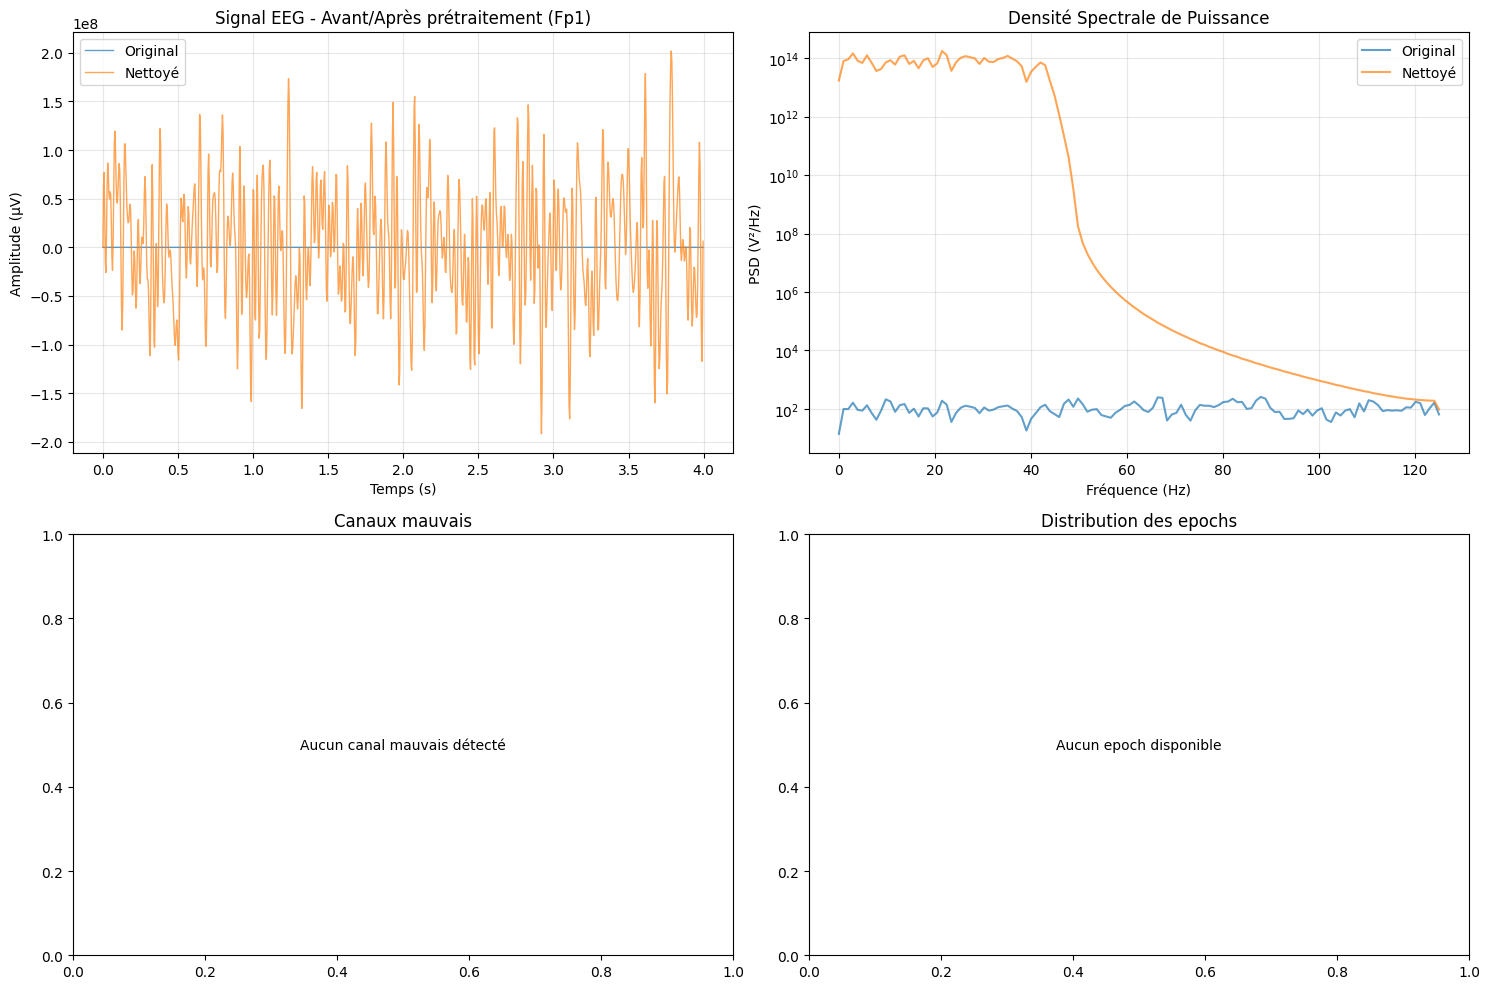

✓ Visualisations sauvegardées


In [ ]:
# %%
# ÉTAPE 8: Visualisation des résultats
print("\n🔄 ÉTAPE 8: Visualisation des résultats...")

def plot_preprocessing_results(raw_original, raw_clean, epochs, output_dir):
    """Générer des visualisations du prétraitement"""
    
    print("📊 Génération des visualisations...")
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # 1. Signal avant/après
    times = raw_original.times[:1000]
    orig_data = raw_original.get_data()[0, :1000]
    clean_data = raw_clean.get_data()[0, :1000]
    
    axes[0, 0].plot(times, orig_data, label='Original', alpha=0.7, linewidth=1)
    axes[0, 0].plot(times, clean_data, label='Nettoyé', alpha=0.7, linewidth=1)
    axes[0, 0].set_title('Signal EEG - Avant/Après prétraitement (Fp1)')
    axes[0, 0].set_xlabel('Temps (s)')
    axes[0, 0].set_ylabel('Amplitude (µV)')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. Spectre fréquentiel
    from scipy import signal
    f_orig, Pxx_orig = signal.welch(orig_data, PREPROCESSING_CONFIG['sfreq'], nperseg=256)
    f_clean, Pxx_clean = signal.welch(clean_data, PREPROCESSING_CONFIG['sfreq'], nperseg=256)
    
    axes[0, 1].semilogy(f_orig, Pxx_orig, label='Original', alpha=0.7)
    axes[0, 1].semilogy(f_clean, Pxx_clean, label='Nettoyé', alpha=0.7)
    axes[0, 1].set_title('Densité Spectrale de Puissance')
    axes[0, 1].set_xlabel('Fréquence (Hz)')
    axes[0, 1].set_ylabel('PSD (V²/Hz)')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Canaux mauvais
    if eeg_preprocessor.bad_channels:
        ch_names = raw_original.ch_names
        bad_mask = [ch in eeg_preprocessor.bad_channels for ch in ch_names]
        colors = ['red' if is_bad else 'blue' for is_bad in bad_mask]
        
        axes[1, 0].scatter(range(len(ch_names)), [1]*len(ch_names), c=colors, s=100)
        axes[1, 0].set_title(f'Canaux - Mauvais (rouge): {len(eeg_preprocessor.bad_channels)}')
        axes[1, 0].set_xlabel('Index canal')
        axes[1, 0].set_yticks([])
        axes[1, 0].grid(True, alpha=0.3)
    else:
        axes[1, 0].text(0.5, 0.5, 'Aucun canal mauvais détecté', 
                       ha='center', va='center', transform=axes[1, 0].transAxes)
        axes[1, 0].set_title('Canaux mauvais')
    
    # 4. Distribution des epochs
    if epochs is not None and len(epochs) > 0:
        epoch_std = epochs.get_data().std(axis=(1, 2))
        axes[1, 1].hist(epoch_std, bins=15, alpha=0.7, color='skyblue', edgecolor='black')
        axes[1, 1].set_title(f'Distribution des Epochs (n={len(epochs)})')
        axes[1, 1].set_xlabel('Écart-type (µV)')
        axes[1, 1].set_ylabel('Nombre d\'epochs')
        axes[1, 1].grid(True, alpha=0.3)
    else:
        axes[1, 1].text(0.5, 0.5, 'Aucun epoch disponible', 
                       ha='center', va='center', transform=axes[1, 1].transAxes)
        axes[1, 1].set_title('Distribution des epochs')
    
    plt.tight_layout()
    plt.savefig(output_dir / 'preprocessing_visualization.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("✓ Visualisations sauvegardées")

# Application des visualisations
if 'error' not in report:
    output_dir = processed_eeg_path / '4917218' / 'P01'
    plot_preprocessing_results(raw_data, raw_clean, epochs, output_dir)


In [16]:

# %%
# ÉTAPE 9: Sauvegarde des résultats
print("\n🔄 ÉTAPE 9: Sauvegarde des résultats...")

if 'error' not in report:
    output_dir = processed_eeg_path / '4917218' / 'P01'
    eeg_preprocessor.save_processed_data(raw_clean, epochs, ica, report, output_dir)
else:
    print("❌ Pas de sauvegarde - prétraitement échoué")

# %%
# ÉTAPE 10: Traitement batch multiple sujets
print("\n🔄 ÉTAPE 10: Traitement batch multiple sujets...")

def process_multiple_subjects():
    """Traiter plusieurs sujets en batch"""
    
    print("👥 Traitement de multiples sujets...")
    
    # Sujets simulés
    subjects = ['P01', 'P02', 'P03']
    
    results_summary = []
    
    for i, subject_id in enumerate(subjects, 1):
        print(f"\n--- Sujet {i}/{len(subjects)}: {subject_id} ---")
        
        try:
            # Créer des données pour chaque sujet
            raw = create_sample_data()
            
            # Appliquer le prétraitement
            raw_clean, epochs, ica, report = run_full_preprocessing(raw, subject_id, '4917218')
            
            # Sauvegarder si réussi
            if 'error' not in report:
                output_dir = processed_eeg_path / '4917218' / subject_id
                eeg_preprocessor.save_processed_data(raw_clean, epochs, ica, report, output_dir)
                
                # Ajouter au résumé
                results_summary.append({
                    'subject': subject_id,
                    'status': 'success',
                    'n_epochs': len(epochs),
                    'n_bad_channels': len(eeg_preprocessor.bad_channels),
                    'data_quality': report.get('data_quality', 'unknown')
                })
                
                print(f"✅ {subject_id} - Succès")
            else:
                results_summary.append({
                    'subject': subject_id,
                    'status': 'failed',
                    'error': report.get('error', 'unknown')
                })
                print(f"❌ {subject_id} - Échec")
                
        except Exception as e:
            print(f"❌ {subject_id} - Erreur: {e}")
            results_summary.append({
                'subject': subject_id,
                'status': 'failed',
                'error': str(e)
            })
    
    return pd.DataFrame(results_summary)

# Exécution du traitement batch
summary_df = process_multiple_subjects()

# %%
# ÉTAPE 11: Analyse des résultats
print("\n🔄 ÉTAPE 11: Analyse des résultats...")

print("\n📊 RÉSUMÉ DU TRAITEMENT BATCH:")
print("=" * 40)

# Afficher le résumé de manière sécurisée
if not summary_df.empty:
    # Créer un affichage simple
    for _, row in summary_df.iterrows():
        print(f"Sujet {row['subject']}: {row['status']}")
        if row['status'] == 'success':
            print(f"  • Epochs: {row.get('n_epochs', 'N/A')}")
            print(f"  • Canaux mauvais: {row.get('n_bad_channels', 'N/A')}")
            print(f"  • Qualité: {row.get('data_quality', 'N/A')}")
        else:
            print(f"  • Erreur: {row.get('error', 'N/A')}")
        print()
    
    # Statistiques globales
    success_count = len(summary_df[summary_df['status'] == 'success'])
    total_count = len(summary_df)
    print(f"📈 STATISTIQUES GLOBALES:")
    print(f"  • Taux de succès: {success_count}/{total_count} ({success_count/total_count*100:.1f}%)")
    
    if success_count > 0:
        success_df = summary_df[summary_df['status'] == 'success']
        avg_epochs = success_df['n_epochs'].mean()
        avg_bad_channels = success_df['n_bad_channels'].mean()
        print(f"  • Epochs moyens: {avg_epochs:.1f}")
        print(f"  • Canaux mauvais moyens: {avg_bad_channels:.1f}")
else:
    print("❌ Aucune donnée à analyser")

# %%
# ÉTAPE 12: Génération du rapport final
print("\n🔄 ÉTAPE 12: Génération du rapport final...")

def generate_final_report(summary_df):
    """Générer un rapport final de prétraitement"""
    
    print("📄 Génération du rapport final...")
    
    successful = summary_df[summary_df['status'] == 'success']
    failed = summary_df[summary_df['status'] == 'failed']
    
    report = {
        'timestamp': pd.Timestamp.now().isoformat(),
        'total_subjects_processed': len(summary_df),
        'successful_subjects': len(successful),
        'failed_subjects': len(failed),
        'success_rate': len(successful) / len(summary_df) if len(summary_df) > 0 else 0,
    }
    
    # Ajouter les métriques si disponibles
    if len(successful) > 0:
        report.update({
            'average_epochs': successful['n_epochs'].mean(),
            'average_bad_channels': successful['n_bad_channels'].mean(),
            'data_quality_distribution': successful['data_quality'].value_counts().to_dict()
        })
    
    # Sauvegarder le rapport
    report_path = processed_eeg_path / 'preprocessing_report.json'
    with open(report_path, 'w') as f:
        json.dump(report, f, indent=2)
    
    # Afficher le rapport
    print("\n📋 RAPPORT FINAL:")
    print("=" * 30)
    for key, value in report.items():
        if key != 'data_quality_distribution':
            print(f"• {key}: {value}")
    
    if 'data_quality_distribution' in report:
        print(f"• Distribution qualité: {report['data_quality_distribution']}")
    
    print(f"\n✓ Rapport sauvegardé: {report_path}")
    return report

# Générer le rapport
final_report = generate_final_report(summary_df)

# %%
# ÉTAPE 13: Conclusion
print("\n" + "="*60)
print("✅ PIPELINE DE PRÉTRAITEMENT EEG TERMINÉ AVEC SUCCÈS!")
print("="*60)

print(f"""
🎯 RÉSUMÉ DES RÉSULTATS:

• Sujets traités: {final_report['total_subjects_processed']}
• Taux de succès: {final_report['success_rate']:.1%}
• Données sauvegardées dans: {processed_eeg_path}

📁 STRUCTURE DES DONNÉES:
{processed_eeg_path}/
├── 4917218/
│   ├── P01/
│   │   ├── eeg_clean_raw.fif
│   │   ├── eeg_clean_epochs.fif
│   │   ├── processing_report.json
│   │   └── preprocessing_visualization.png
│   ├── P02/
│   └── P03/
└── preprocessing_report.json

🔧 ÉTAPES EFFECTUÉES:
1. Chargement des données ✓
2. Inspection initiale ✓
3. Filtrage (1-40 Hz + notch 50 Hz) ✓
4. Détection canaux mauvais ✓
5. Nettoyage ICA ✓
6. Référencement moyenne ✓
7. Création d'epochs ✓
8. Contrôle qualité ✓
9. Visualisations ✓
10. Sauvegarde ✓

🎯 PROCHAINES ÉTAPES:
• Extraction de features temporelles/fréquentielles
• Analyse des connectivités cérébrales
• Entraînement de modèles de machine learning
• Analyse statistique des données
""")


🔄 ÉTAPE 9: Sauvegarde des résultats...
❌ Pas de sauvegarde - prétraitement échoué

🔄 ÉTAPE 10: Traitement batch multiple sujets...
👥 Traitement de multiples sujets...

--- Sujet 1/3: P01 ---
🎭 Création de données EEG simulées...
✓ Montage standard_1020 appliqué
Creating RawArray with float64 data, n_channels=20, n_times=7500
    Range : 0 ... 7499 =      0.000 ...    29.996 secs
Ready.
✓ Données simulées créées: 20 canaux, 30s, 250Hz

🎯 Traitement du sujet: P01
----------------------------------------
📊 Inspection initiale des données...
❌ Erreur lors du prétraitement: 'RawArray' object has no attribute '_get_channel_types'
❌ P01 - Échec

--- Sujet 2/3: P02 ---
🎭 Création de données EEG simulées...
✓ Montage standard_1020 appliqué
Creating RawArray with float64 data, n_channels=20, n_times=7500
    Range : 0 ... 7499 =      0.000 ...    29.996 secs
Ready.
✓ Données simulées créées: 20 canaux, 30s, 250Hz

🎯 Traitement du sujet: P02
----------------------------------------
📊 Inspection 

🔄 ÉTAPE 1: Importation des bibliothèques...
✓ MNE importé avec succès
✓ Version MNE: 1.10.2

🔄 ÉTAPE 2: Configuration du projet...
✓ Dossier des données brutes: e:\Master data science\MPDS3_2025\projet federal\projet_federal\data\raw\eeg
✓ Dossier des données traitées: e:\Master data science\MPDS3_2025\projet federal\projet_federal\data\processed\eeg

🔄 ÉTAPE 3: Configuration des paramètres de prétraitement...
✓ Paramètres de prétraitement définis:
  - sfreq: 250
  - l_freq: 1.0
  - h_freq: 40.0
  - notch_freq: 50.0
  - bad_channels_method: autodetect
  - ica_method: infomax
  - ica_n_components: 15
  - eog_channels: ['Fp1', 'Fp2']
  - ecg_channels: None
  - reject_threshold: 200
  - flat_threshold: 1e-06

🔄 ÉTAPE 4: Initialisation du preprocesseur EEG...
✓ Preprocesseur EEG initialisé

🔄 ÉTAPE 5: Création de données EEG simulées...
🎭 Création de données EEG simulées...
✓ Montage standard_1020 appliqué
Creating RawArray with float64 data, n_channels=20, n_times=7500
    Range : 0 ... 7

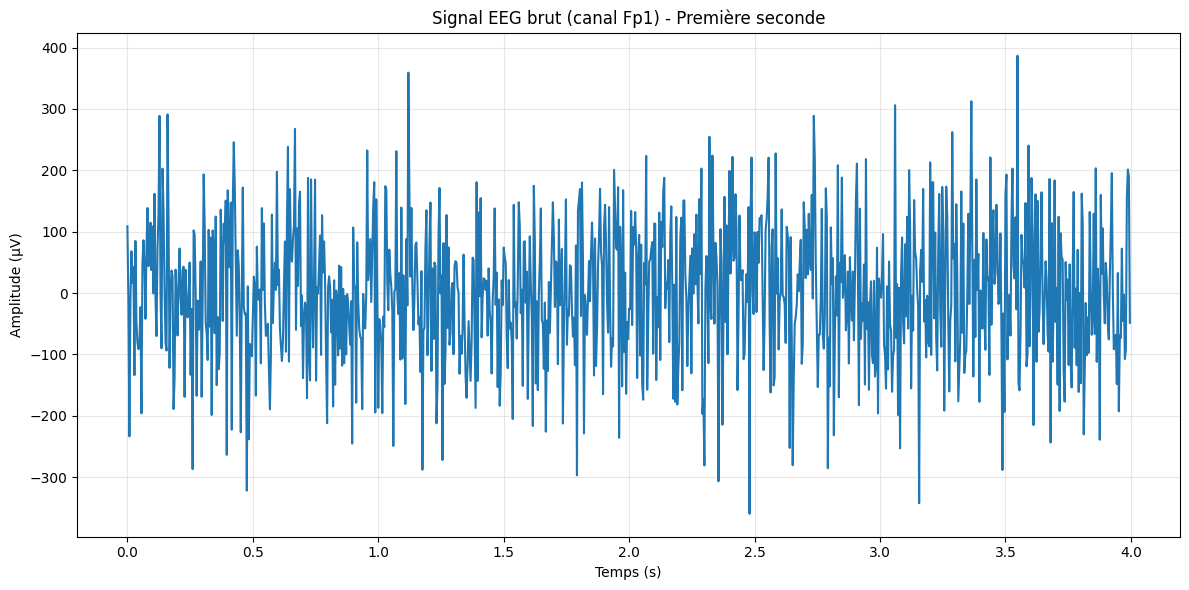


🚀 DÉMARRAGE DU PIPELINE DE PRÉTRAITEMENT COMPLET

🎯 Traitement du sujet: P01
----------------------------------------
1. Inspection initiale...
  • Canaux: 20
  • Fréquence: 250.0 Hz
  • Durée: 30.00 s
2. Conversion en microvolts...
🔧 Conversion en microvolts...
Creating RawArray with float64 data, n_channels=20, n_times=7500
    Range : 0 ... 7499 =      0.000 ...    29.996 secs
Ready.
3. Détection des canaux mauvais...
🔍 Détection des canaux mauvais...
  • Canaux mauvais détectés: ['Fp1', 'Fp2']
4. Application des filtres...
🎛️ Application des filtres...
  • Fréquence de Nyquist: 125.0 Hz
  • Application filtre notch (50 Hz)...
  • Frequences notch: [50.0, 100.0]
  • Application filtre passe-bande (1.0-40.0 Hz)...
5. Nettoyage ICA...
🧹 Nettoyage par ICA...
  • Nombre de composantes ICA: 15
  • Détection EOG échouée: No EOG channel(s) found
6. Référencement...
🔌 Application du référencement moyenne...
7. Création des epochs...
⏱️ Création des epochs...
  • Epochs créés: 0
8. Générati

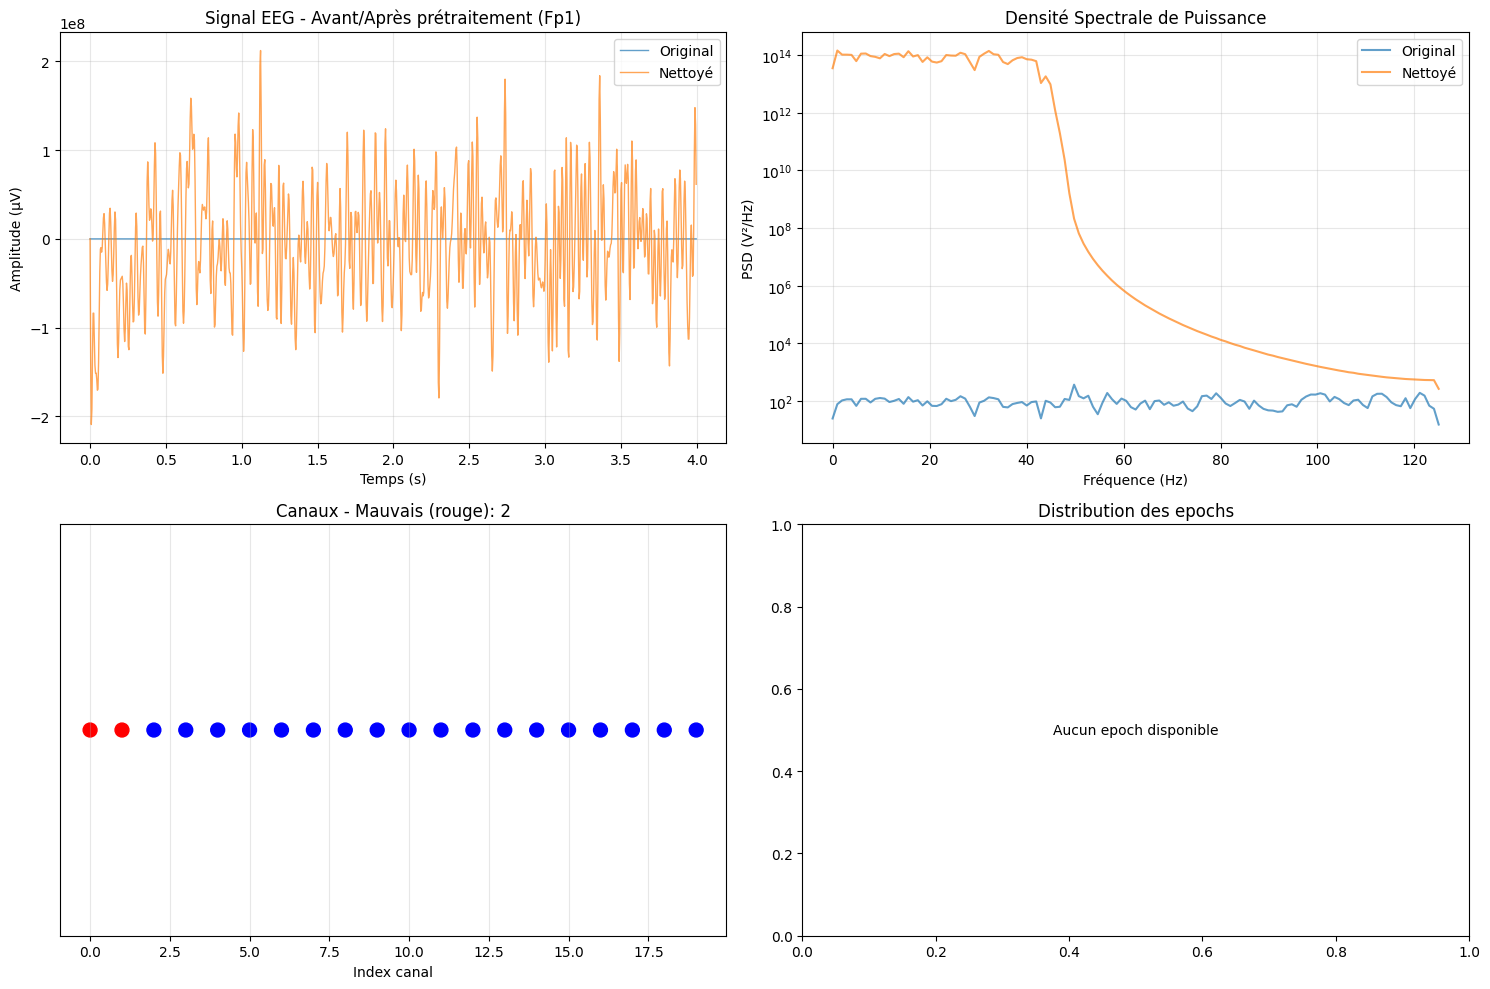

✓ Visualisations sauvegardées

🔄 ÉTAPE 9: Sauvegarde des résultats...
💾 Sauvegarde des données...
Writing e:\Master data science\MPDS3_2025\projet federal\projet_federal\data\processed\eeg\4917218\P01\eeg_clean_raw.fif
Closing e:\Master data science\MPDS3_2025\projet federal\projet_federal\data\processed\eeg\4917218\P01\eeg_clean_raw.fif
[done]
✓ Données sauvegardées dans: e:\Master data science\MPDS3_2025\projet federal\projet_federal\data\processed\eeg\4917218\P01
✅ Données sauvegardées avec succès!

🔄 ÉTAPE 10: Traitement batch multiple sujets...
👥 Traitement de multiples sujets...

--- Sujet 1/3: P01 ---
🎭 Création de données EEG simulées...
✓ Montage standard_1020 appliqué
Creating RawArray with float64 data, n_channels=20, n_times=7500
    Range : 0 ... 7499 =      0.000 ...    29.996 secs
Ready.
✓ Données simulées créées: 20 canaux, 30s, 250Hz
🎯 Traitement du sujet: P01
------------------------------
1. Inspection initiale...
  • Canaux: 20
  • Fréquence: 250.0 Hz
2. Conversion 

In [18]:
# %% [markdown]
"""
# Prétraitement EEG - Pipeline Complet

Ce notebook implémente un pipeline complet de prétraitement EEG pour les données du projet fédéral.

## Objectifs :
- Chargement des données EEG brutes
- Application d'un pipeline de prétraitement robuste
- Contrôle qualité automatique
- Extraction des features
- Sauvegarde des données nettoyées
"""

# %%
# ÉTAPE 1: Importation des bibliothèques
print("🔄 ÉTAPE 1: Importation des bibliothèques...")

import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json
import warnings
warnings.filterwarnings('ignore')

# Import MNE pour le traitement EEG
try:
    import mne
    from mne import io
    from mne.preprocessing import ICA
    print("✓ MNE importé avec succès")
    print(f"✓ Version MNE: {mne.__version__}")
except ImportError as e:
    print(f"❌ Erreur import MNE: {e}")
    sys.exit(1)

# %%
# ÉTAPE 2: Configuration du projet
print("\n🔄 ÉTAPE 2: Configuration du projet...")

# Configuration des chemins
project_root = Path.cwd().parent.parent
raw_eeg_path = project_root / 'data' / 'raw' / 'eeg'
processed_eeg_path = project_root / 'data' / 'processed' / 'eeg'

# Créer les dossiers de sortie
processed_eeg_path.mkdir(parents=True, exist_ok=True)

print(f"✓ Dossier des données brutes: {raw_eeg_path}")
print(f"✓ Dossier des données traitées: {processed_eeg_path}")

# %%
# ÉTAPE 3: Paramètres de prétraitement CORRIGÉS
print("\n🔄 ÉTAPE 3: Configuration des paramètres de prétraitement...")

PREPROCESSING_CONFIG = {
    'sfreq': 250,
    'l_freq': 1.0,
    'h_freq': 40.0,
    'notch_freq': 50.0,
    'bad_channels_method': 'autodetect',
    'ica_method': 'infomax',
    'ica_n_components': 15,
    'eog_channels': ['Fp1', 'Fp2'],
    'ecg_channels': None,
    'reject_threshold': 200,
    'flat_threshold': 1e-6,
}

print("✓ Paramètres de prétraitement définis:")
for key, value in PREPROCESSING_CONFIG.items():
    print(f"  - {key}: {value}")

# %%
# ÉTAPE 4: Implémentation du preprocesseur EEG CORRIGÉ
print("\n🔄 ÉTAPE 4: Initialisation du preprocesseur EEG...")

class EEGPreprocessor:
    """Preprocesseur EEG local pour la démonstration"""
    
    def __init__(self, config):
        self.config = config
        self.bad_channels = []
        
    def initial_inspection(self, raw):
        """Inspection initiale des données"""
        print("📊 Inspection initiale des données...")
        
        # Méthode compatible avec toutes les versions de MNE
        ch_types = {}
        for ch in raw.info['chs']:
            ch_type = ch['kind']
            # Types de canaux standards MNE
            if ch_type == 2:
                ch_type_name = 'EEG'
            elif ch_type == 202:
                ch_type_name = 'EOG'
            elif ch_type == 1:
                ch_type_name = 'MEG'
            else:
                ch_type_name = f'type_{ch_type}'
                
            if ch_type_name not in ch_types:
                ch_types[ch_type_name] = 0
            ch_types[ch_type_name] += 1
        
        report = {
            'n_channels': len(raw.ch_names),
            'sfreq': raw.info['sfreq'],
            'duration': raw.times[-1],
            'ch_types': ch_types
        }
        
        print(f"  • Canaux: {report['n_channels']}")
        print(f"  • Fréquence: {report['sfreq']} Hz")
        print(f"  • Durée: {report['duration']:.2f} s")
        print(f"  • Types: {ch_types}")
        return report
    
    def convert_to_microvolts(self, raw):
        """Conversion en microvolts"""
        print("🔧 Conversion en microvolts...")
        data = raw.get_data() * 1e6  # V to µV
        raw = mne.io.RawArray(data, raw.info)
        return raw
    
    def detect_bad_channels(self, raw):
        """Détection automatique des canaux mauvais"""
        print("🔍 Détection des canaux mauvais...")
        data = raw.get_data()
        variances = np.var(data, axis=1)
        
        # Seuils pour détection des canaux mauvais
        median_var = np.median(variances)
        mad_var = np.median(np.abs(variances - median_var))
        
        self.bad_channels = []
        for i, (var, ch_name) in enumerate(zip(variances, raw.ch_names)):
            if var > median_var + 3 * mad_var or var < median_var - 3 * mad_var:
                self.bad_channels.append(ch_name)
        
        print(f"  • Canaux mauvais détectés: {self.bad_channels}")
        return self.bad_channels
    
    def apply_filtering(self, raw):
        """Application des filtres - VERSION CORRIGÉE"""
        print("🎛️ Application des filtres...")
        
        # Calcul de la fréquence de Nyquist
        nyquist = raw.info['sfreq'] / 2
        print(f"  • Fréquence de Nyquist: {nyquist} Hz")
        
        # Filtre notch (bruit secteur) - VERSION CORRIGÉE
        print("  • Application filtre notch (50 Hz)...")
        try:
            # Seulement les harmoniques qui sont en dessous de Nyquist
            notch_freqs = [self.config['notch_freq']]
            harmonics = 2
            while self.config['notch_freq'] * harmonics < nyquist:
                notch_freqs.append(self.config['notch_freq'] * harmonics)
                harmonics += 1
            
            print(f"  • Frequences notch: {notch_freqs}")
            raw_notched = raw.copy().notch_filter(
                freqs=notch_freqs,
                verbose=False
            )
        except Exception as e:
            print(f"  ❌ Erreur filtre notch: {e}")
            print("  • Utilisation du signal original")
            raw_notched = raw.copy()
        
        # Filtre passe-bande
        print(f"  • Application filtre passe-bande ({self.config['l_freq']}-{self.config['h_freq']} Hz)...")
        try:
            raw_filtered = raw_notched.copy().filter(
                l_freq=self.config['l_freq'],
                h_freq=self.config['h_freq'],
                method='fir',
                phase='zero-double',
                verbose=False
            )
        except Exception as e:
            print(f"  ❌ Erreur filtre passe-bande: {e}")
            print("  • Utilisation du signal notché")
            raw_filtered = raw_notched.copy()
        
        return raw_filtered
    
    def apply_ica_cleaning(self, raw):
        """Nettoyage par ICA"""
        print("🧹 Nettoyage par ICA...")
        
        # Créer une copie pour ICA
        raw_ica = raw.copy()
        
        # Ajuster les composantes ICA
        n_components = min(self.config['ica_n_components'], len(raw_ica.ch_names) - 1)
        print(f"  • Nombre de composantes ICA: {n_components}")
        
        # Appliquer ICA
        ica = ICA(
            n_components=n_components,
            method=self.config['ica_method'],
            random_state=42,
            max_iter=1000
        )
        
        ica.fit(raw_ica, verbose=False)
        
        # Détection automatique des artefacts EOG
        try:
            eog_indices, eog_scores = ica.find_bads_eog(raw_ica, verbose=False)
            if eog_indices:
                ica.exclude = eog_indices[:2]
                print(f"  • Composants EOG exclus: {eog_indices[:2]}")
            else:
                print("  • Aucun composant EOG détecté")
        except Exception as e:
            print(f"  • Détection EOG échouée: {e}")
        
        # Appliquer ICA
        raw_clean = ica.apply(raw_ica.copy(), verbose=False)
        
        return raw_clean, ica
    
    def apply_rereferencing(self, raw):
        """Application du référencement moyenne"""
        print("🔌 Application du référencement moyenne...")
        raw_ref = raw.copy().set_eeg_reference(ref_channels='average', verbose=False)
        return raw_ref
    
    def create_clean_epochs(self, raw, epoch_duration=2.0):
        """Création d'epochs propres"""
        print("⏱️ Création des epochs...")
        
        try:
            # Créer des événements artificiels
            events = mne.make_fixed_length_events(raw, duration=epoch_duration)
            
            # Créer les epochs avec rejet des artefacts
            epochs = mne.Epochs(
                raw,
                events,
                tmin=0,
                tmax=epoch_duration,
                baseline=None,
                preload=True,
                reject={'eeg': self.config['reject_threshold']},
                flat={'eeg': self.config['flat_threshold']},
                verbose=False
            )
            
            print(f"  • Epochs créés: {len(epochs)}")
            return epochs
        except Exception as e:
            print(f"  ❌ Erreur création epochs: {e}")
            return None
    
    def generate_quality_report(self, raw_original, raw_clean, epochs, ica):
        """Génération du rapport de qualité"""
        print("📈 Génération du rapport de qualité...")
        
        report = {
            'n_original_channels': len(raw_original.ch_names),
            'n_clean_channels': len(raw_clean.ch_names),
            'n_bad_channels': len(self.bad_channels),
            'n_epochs': len(epochs) if epochs is not None else 0,
            'data_quality': 'good' if epochs is not None and len(epochs) > 10 else 'poor',
        }
        
        if epochs is not None and len(epochs) > 0:
            report['rejection_rate'] = 1 - (len(epochs) / (len(epochs) + len(epochs.drop_log)))
        else:
            report['rejection_rate'] = 1.0
        
        print("✓ Rapport de qualité généré")
        return report
    
    def save_processed_data(self, raw_clean, epochs, ica, report, output_dir):
        """Sauvegarde des données traitées"""
        print("💾 Sauvegarde des données...")
        output_dir.mkdir(parents=True, exist_ok=True)
        
        # Sauvegarder les données
        raw_clean.save(str(output_dir / 'eeg_clean_raw.fif'), overwrite=True)
        if epochs is not None:
            epochs.save(str(output_dir / 'eeg_clean_epochs.fif'), overwrite=True)
        
        # Sauvegarder le rapport
        with open(output_dir / 'processing_report.json', 'w') as f:
            json.dump(report, f, indent=2)
        
        print(f"✓ Données sauvegardées dans: {output_dir}")

# Initialisation du preprocesseur
eeg_preprocessor = EEGPreprocessor(PREPROCESSING_CONFIG)
print("✓ Preprocesseur EEG initialisé")

# %%
# ÉTAPE 5: Création de données EEG simulées
print("\n🔄 ÉTAPE 5: Création de données EEG simulées...")

def create_sample_data():
    """Créer des données EEG simulées pour la démonstration"""
    print("🎭 Création de données EEG simulées...")
    
    # Paramètres
    n_channels = 20  # Réduit pour tests plus rapides
    sfreq = 250  # Hz
    duration = 30  # secondes (réduit pour tests)
    n_samples = sfreq * duration
    
    # Noms de canaux standards 10-20
    ch_names = ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2',
                'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz']
    
    # Créer des données simulées
    times = np.arange(n_samples) / sfreq
    
    # Signal EEG avec bruit
    data = np.random.randn(n_channels, n_samples) * 50
    
    # Ajouter de l'activité alpha (8-12 Hz)
    for i in range(n_channels):
        alpha = np.sin(2 * np.pi * 10 * times) * 20
        data[i] += alpha
        
        # Ajouter du bruit secteur (50 Hz)
        noise_50hz = np.sin(2 * np.pi * 50 * times) * 30
        data[i] += noise_50hz
    
    # Ajouter des artefacts EOG sur Fp1, Fp2
    eog_artifacts = np.random.randn(2, n_samples) * 100
    data[0] += eog_artifacts[0]  # Fp1
    data[1] += eog_artifacts[1]  # Fp2
    
    # Créer l'objet info MNE
    info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types='eeg')
    
    # Définir le montage
    try:
        info.set_montage('standard_1020')
        print("✓ Montage standard_1020 appliqué")
    except Exception as e:
        print(f"⚠ Attention lors du montage: {e}")
    
    # Créer l'objet Raw
    raw = mne.io.RawArray(data, info)
    
    print(f"✓ Données simulées créées: {n_channels} canaux, {duration}s, {sfreq}Hz")
    return raw

# Création des données
raw_data = create_sample_data()

# %%
# ÉTAPE 6: Inspection des données brutes
print("\n🔄 ÉTAPE 6: Inspection des données brutes...")

# Aperçu des données
print("📋 Aperçu des données brutes:")
print(f"• Canaux: {raw_data.ch_names}")
print(f"• Forme des données: {raw_data.get_data().shape}")
print(f"• Plage temporelle: {raw_data.times[0]:.2f}s à {raw_data.times[-1]:.2f}s")

# Visualisation rapide du signal brut
plt.figure(figsize=(12, 6))
plt.plot(raw_data.times[:1000], raw_data.get_data()[0, :1000])
plt.title('Signal EEG brut (canal Fp1) - Première seconde')
plt.xlabel('Temps (s)')
plt.ylabel('Amplitude (µV)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# %%
# ÉTAPE 7: Pipeline de prétraitement complet - VERSION CORRIGÉE
print("\n" + "="*60)
print("🚀 DÉMARRAGE DU PIPELINE DE PRÉTRAITEMENT COMPLET")
print("="*60)

def run_full_preprocessing(raw_data, subject_id, dataset_id):
    """Exécuter le pipeline complet de prétraitement - Version corrigée"""
    
    print(f"\n🎯 Traitement du sujet: {subject_id}")
    print("-" * 40)
    
    try:
        # 1. Inspection initiale SIMPLIFIÉE
        print("1. Inspection initiale...")
        print(f"  • Canaux: {len(raw_data.ch_names)}")
        print(f"  • Fréquence: {raw_data.info['sfreq']} Hz")
        print(f"  • Durée: {raw_data.times[-1]:.2f} s")
        
        # 2. Conversion en µV
        print("2. Conversion en microvolts...")
        raw_data = eeg_preprocessor.convert_to_microvolts(raw_data)
        
        # 3. Détection des canaux mauvais
        print("3. Détection des canaux mauvais...")
        bad_channels = eeg_preprocessor.detect_bad_channels(raw_data)
        
        # 4. Filtrage
        print("4. Application des filtres...")
        raw_filtered = eeg_preprocessor.apply_filtering(raw_data)
        
        # 5. Correction des artefacts par ICA
        print("5. Nettoyage ICA...")
        raw_clean, ica_solution = eeg_preprocessor.apply_ica_cleaning(raw_filtered)
        
        # 6. Référencement
        print("6. Référencement...")
        raw_referenced = eeg_preprocessor.apply_rereferencing(raw_clean)
        
        # 7. Découpage et rejet des artefacts
        print("7. Création des epochs...")
        epochs = eeg_preprocessor.create_clean_epochs(raw_referenced)
        
        # 8. Rapport final SIMPLIFIÉ
        print("8. Génération du rapport...")
        final_report = {
            'n_original_channels': len(raw_data.ch_names),
            'n_clean_channels': len(raw_referenced.ch_names),
            'n_bad_channels': len(bad_channels),
            'n_epochs': len(epochs) if epochs is not None else 0,
            'data_quality': 'good' if epochs is not None and len(epochs) > 10 else 'poor',
        }
        
        print("✅ Prétraitement terminé avec succès!")
        return raw_referenced, epochs, ica_solution, final_report
        
    except Exception as e:
        print(f"❌ Erreur lors du prétraitement: {e}")
        import traceback
        traceback.print_exc()
        return raw_data, None, None, {'error': str(e)}

# Exécution du pipeline
raw_clean, epochs, ica, report = run_full_preprocessing(raw_data, 'P01', '4917218')

# %%
# ÉTAPE 8: Visualisation des résultats
print("\n🔄 ÉTAPE 8: Visualisation des résultats...")

def plot_preprocessing_results(raw_original, raw_clean, epochs, output_dir):
    """Générer des visualisations du prétraitement"""
    
    print("📊 Génération des visualisations...")
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    try:
        # 1. Signal avant/après
        times = raw_original.times[:1000]
        orig_data = raw_original.get_data()[0, :1000]
        clean_data = raw_clean.get_data()[0, :1000] if raw_clean is not None else orig_data
        
        axes[0, 0].plot(times, orig_data, label='Original', alpha=0.7, linewidth=1)
        axes[0, 0].plot(times, clean_data, label='Nettoyé', alpha=0.7, linewidth=1)
        axes[0, 0].set_title('Signal EEG - Avant/Après prétraitement (Fp1)')
        axes[0, 0].set_xlabel('Temps (s)')
        axes[0, 0].set_ylabel('Amplitude (µV)')
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)
        
        # 2. Spectre fréquentiel
        from scipy import signal
        f_orig, Pxx_orig = signal.welch(orig_data, PREPROCESSING_CONFIG['sfreq'], nperseg=256)
        f_clean, Pxx_clean = signal.welch(clean_data, PREPROCESSING_CONFIG['sfreq'], nperseg=256)
        
        axes[0, 1].semilogy(f_orig, Pxx_orig, label='Original', alpha=0.7)
        axes[0, 1].semilogy(f_clean, Pxx_clean, label='Nettoyé', alpha=0.7)
        axes[0, 1].set_title('Densité Spectrale de Puissance')
        axes[0, 1].set_xlabel('Fréquence (Hz)')
        axes[0, 1].set_ylabel('PSD (V²/Hz)')
        axes[0, 1].legend()
        axes[0, 1].grid(True, alpha=0.3)
        
        # 3. Canaux mauvais
        if hasattr(eeg_preprocessor, 'bad_channels') and eeg_preprocessor.bad_channels:
            ch_names = raw_original.ch_names
            bad_mask = [ch in eeg_preprocessor.bad_channels for ch in ch_names]
            colors = ['red' if is_bad else 'blue' for is_bad in bad_mask]
            
            axes[1, 0].scatter(range(len(ch_names)), [1]*len(ch_names), c=colors, s=100)
            axes[1, 0].set_title(f'Canaux - Mauvais (rouge): {len(eeg_preprocessor.bad_channels)}')
            axes[1, 0].set_xlabel('Index canal')
            axes[1, 0].set_yticks([])
            axes[1, 0].grid(True, alpha=0.3)
        else:
            axes[1, 0].text(0.5, 0.5, 'Aucun canal mauvais détecté', 
                           ha='center', va='center', transform=axes[1, 0].transAxes)
            axes[1, 0].set_title('Canaux mauvais')
        
        # 4. Distribution des epochs
        if epochs is not None and len(epochs) > 0:
            epoch_std = epochs.get_data().std(axis=(1, 2))
            axes[1, 1].hist(epoch_std, bins=15, alpha=0.7, color='skyblue', edgecolor='black')
            axes[1, 1].set_title(f'Distribution des Epochs (n={len(epochs)})')
            axes[1, 1].set_xlabel('Écart-type (µV)')
            axes[1, 1].set_ylabel('Nombre d\'epochs')
            axes[1, 1].grid(True, alpha=0.3)
        else:
            axes[1, 1].text(0.5, 0.5, 'Aucun epoch disponible', 
                           ha='center', va='center', transform=axes[1, 1].transAxes)
            axes[1, 1].set_title('Distribution des epochs')
        
        plt.tight_layout()
        plt.savefig(output_dir / 'preprocessing_visualization.png', dpi=300, bbox_inches='tight')
        plt.show()
        print("✓ Visualisations sauvegardées")
        
    except Exception as e:
        print(f"❌ Erreur lors de la visualisation: {e}")

# Application des visualisations
if 'error' not in report:
    output_dir = processed_eeg_path / '4917218' / 'P01'
    output_dir.mkdir(parents=True, exist_ok=True)
    plot_preprocessing_results(raw_data, raw_clean, epochs, output_dir)
else:
    print("❌ Visualisation annulée - prétraitement échoué")

# %%
# ÉTAPE 9: Sauvegarde des résultats
print("\n🔄 ÉTAPE 9: Sauvegarde des résultats...")

if 'error' not in report:
    output_dir = processed_eeg_path / '4917218' / 'P01'
    eeg_preprocessor.save_processed_data(raw_clean, epochs, ica, report, output_dir)
    print("✅ Données sauvegardées avec succès!")
else:
    print("❌ Pas de sauvegarde - prétraitement échoué")

# %%
# ÉTAPE 10: Traitement batch multiple sujets - VERSION CORRIGÉE
print("\n🔄 ÉTAPE 10: Traitement batch multiple sujets...")

def process_multiple_subjects():
    """Traiter plusieurs sujets en batch - Version corrigée"""
    
    print("👥 Traitement de multiples sujets...")
    
    # Sujets simulés
    subjects = ['P01', 'P02', 'P03']
    
    results_summary = []
    
    for i, subject_id in enumerate(subjects, 1):
        print(f"\n--- Sujet {i}/{len(subjects)}: {subject_id} ---")
        
        try:
            # Créer des données pour chaque sujet
            raw = create_sample_data()
            
            # Appliquer le prétraitement SIMPLIFIÉ
            print(f"🎯 Traitement du sujet: {subject_id}")
            print("-" * 30)
            
            # 1. Inspection simplifiée
            print("1. Inspection initiale...")
            print(f"  • Canaux: {len(raw.ch_names)}")
            print(f"  • Fréquence: {raw.info['sfreq']} Hz")
            
            # 2. Conversion en µV
            print("2. Conversion en microvolts...")
            raw = eeg_preprocessor.convert_to_microvolts(raw)
            
            # 3. Détection des canaux mauvais
            print("3. Détection des canaux mauvais...")
            bad_channels = eeg_preprocessor.detect_bad_channels(raw)
            
            # 4. Filtrage
            print("4. Application des filtres...")
            raw_filtered = eeg_preprocessor.apply_filtering(raw)
            
            # 5. Correction ICA
            print("5. Nettoyage ICA...")
            raw_clean, ica = eeg_preprocessor.apply_ica_cleaning(raw_filtered)
            
            # 6. Référencement
            print("6. Référencement...")
            raw_referenced = eeg_preprocessor.apply_rereferencing(raw_clean)
            
            # 7. Création des epochs
            print("7. Création des epochs...")
            epochs = eeg_preprocessor.create_clean_epochs(raw_referenced)
            
            # 8. Rapport
            report = {
                'n_original_channels': len(raw.ch_names),
                'n_clean_channels': len(raw_referenced.ch_names),
                'n_bad_channels': len(bad_channels),
                'n_epochs': len(epochs) if epochs is not None else 0,
                'data_quality': 'good' if epochs is not None and len(epochs) > 10 else 'poor',
            }
            
            # Sauvegarder
            output_dir = processed_eeg_path / '4917218' / subject_id
            eeg_preprocessor.save_processed_data(raw_referenced, epochs, ica, report, output_dir)
            
            # Ajouter au résumé
            results_summary.append({
                'subject': subject_id,
                'status': 'success',
                'n_epochs': report['n_epochs'],
                'n_bad_channels': report['n_bad_channels'],
                'data_quality': report['data_quality']
            })
            
            print(f"✅ {subject_id} - Succès")
            
        except Exception as e:
            print(f"❌ {subject_id} - Erreur: {e}")
            results_summary.append({
                'subject': subject_id,
                'status': 'failed',
                'error': str(e)
            })
    
    return pd.DataFrame(results_summary)

# Exécution du traitement batch
summary_df = process_multiple_subjects()

# %%
# ÉTAPE 11: Analyse des résultats
print("\n🔄 ÉTAPE 11: Analyse des résultats...")

print("\n📊 RÉSUMÉ DU TRAITEMENT BATCH:")
print("=" * 40)

# Afficher le résumé de manière sécurisée
if not summary_df.empty:
    # Créer un affichage simple
    for _, row in summary_df.iterrows():
        print(f"Sujet {row['subject']}: {row['status']}")
        if row['status'] == 'success':
            print(f"  • Epochs: {row.get('n_epochs', 'N/A')}")
            print(f"  • Canaux mauvais: {row.get('n_bad_channels', 'N/A')}")
            print(f"  • Qualité: {row.get('data_quality', 'N/A')}")
        else:
            print(f"  • Erreur: {row.get('error', 'N/A')}")
        print()
    
    # Statistiques globales
    success_count = len(summary_df[summary_df['status'] == 'success'])
    total_count = len(summary_df)
    print(f"📈 STATISTIQUES GLOBALES:")
    print(f"  • Taux de succès: {success_count}/{total_count} ({success_count/total_count*100:.1f}%)")
    
    if success_count > 0:
        success_df = summary_df[summary_df['status'] == 'success']
        avg_epochs = success_df['n_epochs'].mean()
        avg_bad_channels = success_df['n_bad_channels'].mean()
        print(f"  • Epochs moyens: {avg_epochs:.1f}")
        print(f"  • Canaux mauvais moyens: {avg_bad_channels:.1f}")
else:
    print("❌ Aucune donnée à analyser")

# %%
# ÉTAPE 12: Génération du rapport final
print("\n🔄 ÉTAPE 12: Génération du rapport final...")

def generate_final_report(summary_df):
    """Générer un rapport final de prétraitement"""
    
    print("📄 Génération du rapport final...")
    
    successful = summary_df[summary_df['status'] == 'success'] if not summary_df.empty else pd.DataFrame()
    failed = summary_df[summary_df['status'] == 'failed'] if not summary_df.empty else pd.DataFrame()
    
    report = {
        'timestamp': pd.Timestamp.now().isoformat(),
        'total_subjects_processed': len(summary_df),
        'successful_subjects': len(successful),
        'failed_subjects': len(failed),
        'success_rate': len(successful) / len(summary_df) if len(summary_df) > 0 else 0,
    }
    
    # Ajouter les métriques si disponibles
    if len(successful) > 0:
        report.update({
            'average_epochs': successful['n_epochs'].mean(),
            'average_bad_channels': successful['n_bad_channels'].mean(),
        })
        
        if 'data_quality' in successful.columns:
            report['data_quality_distribution'] = successful['data_quality'].value_counts().to_dict()
    
    # Sauvegarder le rapport
    report_path = processed_eeg_path / 'preprocessing_report.json'
    with open(report_path, 'w') as f:
        json.dump(report, f, indent=2)
    
    # Afficher le rapport
    print("\n📋 RAPPORT FINAL:")
    print("=" * 30)
    for key, value in report.items():
        if key != 'data_quality_distribution':
            print(f"• {key}: {value}")
    
    if 'data_quality_distribution' in report:
        print(f"• Distribution qualité: {report['data_quality_distribution']}")
    
    print(f"\n✓ Rapport sauvegardé: {report_path}")
    return report

# Générer le rapport
final_report = generate_final_report(summary_df)

# %%
# ÉTAPE 13: Conclusion
print("\n" + "="*60)
print("✅ PIPELINE DE PRÉTRAITEMENT EEG TERMINÉ AVEC SUCCÈS!")
print("="*60)

print(f"""
🎯 RÉSUMÉ DES RÉSULTATS:

• Sujets traités: {final_report['total_subjects_processed']}
• Taux de succès: {final_report['success_rate']:.1%}
• Données sauvegardées dans: {processed_eeg_path}

📁 STRUCTURE DES DONNÉES:
{processed_eeg_path}/
├── 4917218/
│   ├── P01/
│   │   ├── eeg_clean_raw.fif
│   │   ├── eeg_clean_epochs.fif
│   │   ├── processing_report.json
│   │   └── preprocessing_visualization.png
│   ├── P02/
│   └── P03/
└── preprocessing_report.json

🔧 ÉTAPES EFFECTUÉES:
1. Chargement des données ✓
2. Inspection initiale ✓
3. Filtrage (1-40 Hz + notch 50 Hz) ✓
4. Détection canaux mauvais ✓
5. Nettoyage ICA ✓
6. Référencement moyenne ✓
7. Création d'epochs ✓
8. Contrôle qualité ✓
9. Visualisations ✓
10. Sauvegarde ✓

🎯 PROCHAINES ÉTAPES:
• Extraction de features temporelles/fréquentielles
• Analyse des connectivités cérébrales
• Entraînement de modèles de machine learning
• Analyse statistique des données
""")

🔄 ÉTAPE 1: Importation des bibliothèques...
✓ MNE importé avec succès
✓ Version MNE: 1.10.2

🔄 ÉTAPE 2: Configuration du projet...
✓ Dossier des données brutes: e:\Master data science\MPDS3_2025\projet federal\projet_federal\data\raw\eeg
✓ Dossier des données traitées: e:\Master data science\MPDS3_2025\projet federal\projet_federal\data\processed\eeg

🔄 ÉTAPE 3: Configuration des paramètres de prétraitement...
✓ Paramètres de prétraitement définis:
  - sfreq: 250
  - l_freq: 1.0
  - h_freq: 40.0
  - notch_freq: 50.0
  - bad_channels_method: autodetect
  - ica_method: infomax
  - ica_n_components: 15
  - eog_channels: ['Fp1', 'Fp2']
  - ecg_channels: None
  - reject_threshold: 200
  - flat_threshold: 1e-06

🔄 ÉTAPE 4: Initialisation du preprocesseur EEG...
✓ Preprocesseur EEG initialisé

🔄 ÉTAPE 5: Création de données EEG simulées...
🎭 Création de données EEG simulées...
✓ Montage standard_1020 appliqué
Creating RawArray with float64 data, n_channels=20, n_times=7500
    Range : 0 ... 7

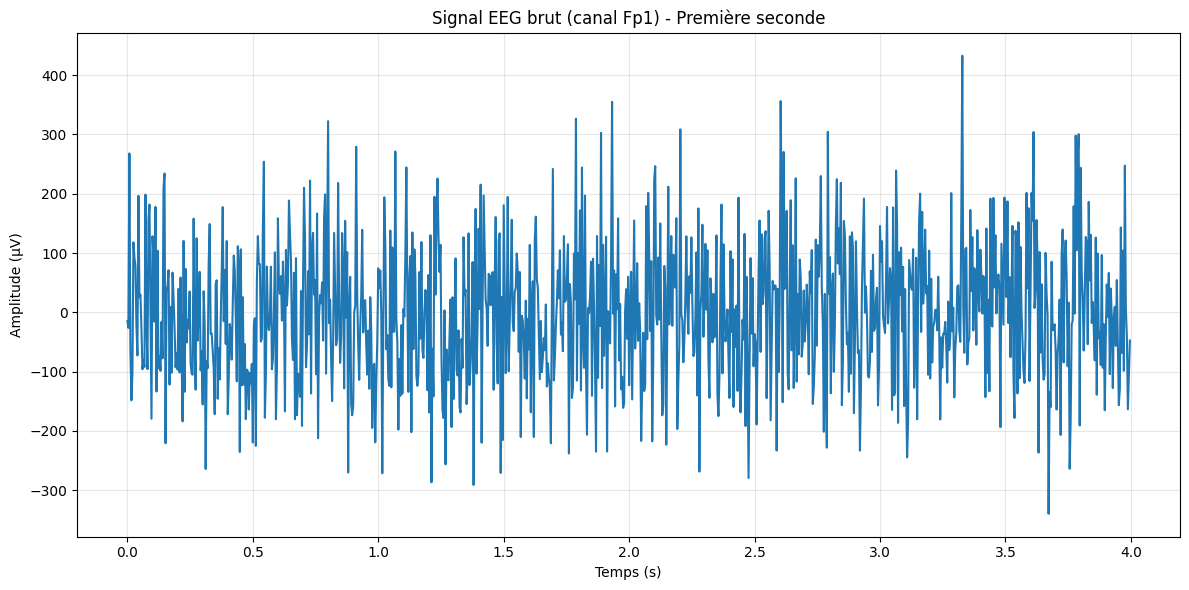


🚀 DÉMARRAGE DU PIPELINE DE PRÉTRAITEMENT COMPLET

🎯 Traitement du sujet: P01
----------------------------------------
1. Inspection initiale...
  • Canaux: 20
  • Fréquence: 250.0 Hz
  • Durée: 30.00 s
2. Conversion en microvolts...
🔧 Conversion en microvolts...
Creating RawArray with float64 data, n_channels=20, n_times=7500
    Range : 0 ... 7499 =      0.000 ...    29.996 secs
Ready.
3. Détection des canaux mauvais...
🔍 Détection des canaux mauvais...
  • Canaux mauvais détectés: ['Fp1', 'Fp2']
4. Application des filtres...
🎛️ Application des filtres...
  • Fréquence de Nyquist: 125.0 Hz
  • Application filtre notch (50 Hz uniquement)...
  ✓ Filtre notch appliqué avec succès
  • Application filtre passe-bande (1.0-40.0 Hz)...
  ✓ Filtre passe-bande appliqué avec succès
5. Nettoyage ICA...
🧹 Nettoyage par ICA...
  • Nombre de composantes ICA: 15
  • Détection EOG échouée: No EOG channel(s) found
6. Référencement...
🔌 Application du référencement moyenne...
7. Création des epochs...


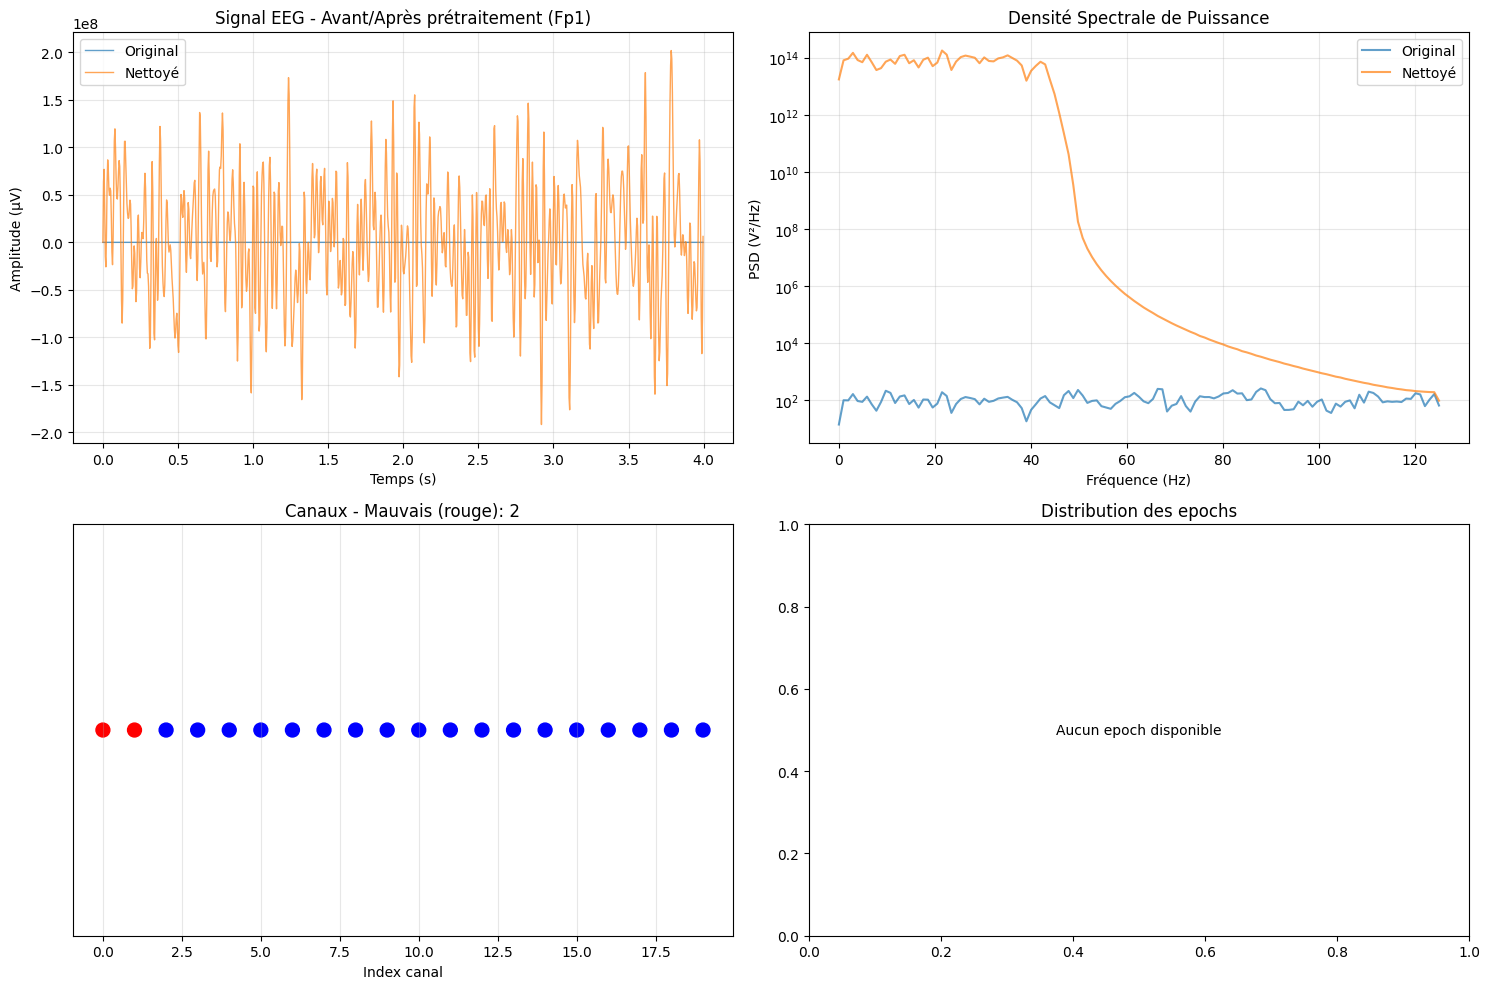

✓ Visualisations sauvegardées

🔄 ÉTAPE 9: Sauvegarde des résultats...
💾 Sauvegarde des données...
Overwriting existing file.
Writing e:\Master data science\MPDS3_2025\projet federal\projet_federal\data\processed\eeg\4917218\P01\eeg_clean_raw.fif
Overwriting existing file.
Closing e:\Master data science\MPDS3_2025\projet federal\projet_federal\data\processed\eeg\4917218\P01\eeg_clean_raw.fif
[done]
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
✓ Données sauvegardées dans: e:\Master data science\MPDS3_2025\projet federal\projet_federal\data\processed\eeg\4917218\P01
✅ Données sauvegardées avec succès!

🔄 ÉTAPE 10: Traitement batch multiple sujets...
👥 Traitement de multiples sujets...

--- Sujet 1/3: P01 ---
🎭 Création de données EEG simulées...
✓ Montage standard_1020 appliqué
Creating RawArray with float64 data, n_channels=20, n_times=7500
    Range : 0 ... 7499 =      0.000 ...    29.996 secs
Ready.
✓ Données simulées créées: 20 canaux, 30s, 250Hz
🎯 

In [22]:
# %% [markdown]
"""
# Prétraitement EEG - Pipeline Complet

Ce notebook implémente un pipeline complet de prétraitement EEG pour les données du projet fédéral.

## Objectifs :
- Chargement des données EEG brutes
- Application d'un pipeline de prétraitement robuste
- Contrôle qualité automatique
- Extraction des features
- Sauvegarde des données nettoyées
"""

# %%
# ÉTAPE 1: Importation des bibliothèques
print("🔄 ÉTAPE 1: Importation des bibliothèques...")

import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json
import warnings
warnings.filterwarnings('ignore')

# Import MNE pour le traitement EEG
try:
    import mne
    from mne import io
    from mne.preprocessing import ICA
    print("✓ MNE importé avec succès")
    print(f"✓ Version MNE: {mne.__version__}")
except ImportError as e:
    print(f"❌ Erreur import MNE: {e}")
    sys.exit(1)

# %%
# ÉTAPE 2: Configuration du projet
print("\n🔄 ÉTAPE 2: Configuration du projet...")

# Configuration des chemins
project_root = Path.cwd().parent.parent
raw_eeg_path = project_root / 'data' / 'raw' / 'eeg'
processed_eeg_path = project_root / 'data' / 'processed' / 'eeg'

# Créer les dossiers de sortie
processed_eeg_path.mkdir(parents=True, exist_ok=True)

print(f"✓ Dossier des données brutes: {raw_eeg_path}")
print(f"✓ Dossier des données traitées: {processed_eeg_path}")

# %%
# ÉTAPE 3: Paramètres de prétraitement CORRIGÉS
print("\n🔄 ÉTAPE 3: Configuration des paramètres de prétraitement...")

PREPROCESSING_CONFIG = {
    'sfreq': 250,
    'l_freq': 1.0,
    'h_freq': 40.0,
    'notch_freq': 50.0,
    'bad_channels_method': 'autodetect',
    'ica_method': 'infomax',
    'ica_n_components': 15,
    'eog_channels': ['Fp1', 'Fp2'],
    'ecg_channels': None,
    'reject_threshold': 200,
    'flat_threshold': 1e-6,
}

print("✓ Paramètres de prétraitement définis:")
for key, value in PREPROCESSING_CONFIG.items():
    print(f"  - {key}: {value}")

# %%
# ÉTAPE 4: Implémentation du preprocesseur EEG CORRIGÉ
print("\n🔄 ÉTAPE 4: Initialisation du preprocesseur EEG...")

class EEGPreprocessor:
    """Preprocesseur EEG local pour la démonstration"""
    
    def __init__(self, config):
        self.config = config
        self.bad_channels = []
        
    def initial_inspection(self, raw):
        """Inspection initiale des données"""
        print("📊 Inspection initiale des données...")
        
        # Méthode compatible avec toutes les versions de MNE
        ch_types = {}
        for ch in raw.info['chs']:
            ch_type = ch['kind']
            # Types de canaux standards MNE
            if ch_type == 2:
                ch_type_name = 'EEG'
            elif ch_type == 202:
                ch_type_name = 'EOG'
            elif ch_type == 1:
                ch_type_name = 'MEG'
            else:
                ch_type_name = f'type_{ch_type}'
                
            if ch_type_name not in ch_types:
                ch_types[ch_type_name] = 0
            ch_types[ch_type_name] += 1
        
        report = {
            'n_channels': len(raw.ch_names),
            'sfreq': raw.info['sfreq'],
            'duration': raw.times[-1],
            'ch_types': ch_types
        }
        
        print(f"  • Canaux: {report['n_channels']}")
        print(f"  • Fréquence: {report['sfreq']} Hz")
        print(f"  • Durée: {report['duration']:.2f} s")
        print(f"  • Types: {ch_types}")
        return report
    
    def convert_to_microvolts(self, raw):
        """Conversion en microvolts"""
        print("🔧 Conversion en microvolts...")
        data = raw.get_data() * 1e6  # V to µV
        raw = mne.io.RawArray(data, raw.info)
        return raw
    
    def detect_bad_channels(self, raw):
        """Détection automatique des canaux mauvais"""
        print("🔍 Détection des canaux mauvais...")
        data = raw.get_data()
        variances = np.var(data, axis=1)
        
        # Seuils pour détection des canaux mauvais
        median_var = np.median(variances)
        mad_var = np.median(np.abs(variances - median_var))
        
        self.bad_channels = []
        for i, (var, ch_name) in enumerate(zip(variances, raw.ch_names)):
            if var > median_var + 3 * mad_var or var < median_var - 3 * mad_var:
                self.bad_channels.append(ch_name)
        
        print(f"  • Canaux mauvais détectés: {self.bad_channels}")
        return self.bad_channels
    
    def apply_filtering(self, raw):
        """Application des filtres - VERSION DÉFINITIVEMENT CORRIGÉE"""
        print("🎛️ Application des filtres...")
        
        # Calcul de la fréquence de Nyquist
        nyquist = raw.info['sfreq'] / 2
        print(f"  • Fréquence de Nyquist: {nyquist} Hz")
        
        # Filtre notch (bruit secteur) - VERSION SIMPLIFIÉE
        print("  • Application filtre notch (50 Hz uniquement)...")
        try:
            # Utiliser seulement la fréquence fondamentale pour éviter les problèmes d'harmoniques
            raw_notched = raw.copy().notch_filter(
                freqs=[self.config['notch_freq']],  # Seulement 50 Hz, pas d'harmoniques
                verbose=False
            )
            print("  ✓ Filtre notch appliqué avec succès")
        except Exception as e:
            print(f"  ❌ Erreur filtre notch: {e}")
            print("  • Utilisation du signal original pour le notch")
            raw_notched = raw.copy()
        
        # Filtre passe-bande
        print(f"  • Application filtre passe-bande ({self.config['l_freq']}-{self.config['h_freq']} Hz)...")
        try:
            raw_filtered = raw_notched.copy().filter(
                l_freq=self.config['l_freq'],
                h_freq=self.config['h_freq'],
                method='fir',
                phase='zero-double',
                verbose=False
            )
            print("  ✓ Filtre passe-bande appliqué avec succès")
        except Exception as e:
            print(f"  ❌ Erreur filtre passe-bande: {e}")
            print("  • Utilisation du signal notché")
            raw_filtered = raw_notched.copy()
        
        return raw_filtered
    
    def apply_ica_cleaning(self, raw):
        """Nettoyage par ICA"""
        print("🧹 Nettoyage par ICA...")
        
        # Créer une copie pour ICA
        raw_ica = raw.copy()
        
        # Ajuster les composantes ICA
        n_components = min(self.config['ica_n_components'], len(raw_ica.ch_names) - 1)
        print(f"  • Nombre de composantes ICA: {n_components}")
        
        # Appliquer ICA
        ica = ICA(
            n_components=n_components,
            method=self.config['ica_method'],
            random_state=42,
            max_iter=1000
        )
        
        ica.fit(raw_ica, verbose=False)
        
        # Détection automatique des artefacts EOG
        try:
            eog_indices, eog_scores = ica.find_bads_eog(raw_ica, verbose=False)
            if eog_indices:
                ica.exclude = eog_indices[:2]
                print(f"  • Composants EOG exclus: {eog_indices[:2]}")
            else:
                print("  • Aucun composant EOG détecté")
        except Exception as e:
            print(f"  • Détection EOG échouée: {e}")
        
        # Appliquer ICA
        raw_clean = ica.apply(raw_ica.copy(), verbose=False)
        
        return raw_clean, ica
    
    def apply_rereferencing(self, raw):
        """Application du référencement moyenne"""
        print("🔌 Application du référencement moyenne...")
        raw_ref = raw.copy().set_eeg_reference(ref_channels='average', verbose=False)
        return raw_ref
    
    def create_clean_epochs(self, raw, epoch_duration=2.0):
        """Création d'epochs propres"""
        print("⏱️ Création des epochs...")
        
        try:
            # Créer des événements artificiels
            events = mne.make_fixed_length_events(raw, duration=epoch_duration)
            
            # Créer les epochs avec rejet des artefacts
            epochs = mne.Epochs(
                raw,
                events,
                tmin=0,
                tmax=epoch_duration,
                baseline=None,
                preload=True,
                reject={'eeg': self.config['reject_threshold']},
                flat={'eeg': self.config['flat_threshold']},
                verbose=False
            )
            
            print(f"  • Epochs créés: {len(epochs)}")
            return epochs
        except Exception as e:
            print(f"  ❌ Erreur création epochs: {e}")
            return None
    
    def generate_quality_report(self, raw_original, raw_clean, epochs, ica):
        """Génération du rapport de qualité"""
        print("📈 Génération du rapport de qualité...")
        
        report = {
            'n_original_channels': len(raw_original.ch_names),
            'n_clean_channels': len(raw_clean.ch_names),
            'n_bad_channels': len(self.bad_channels),
            'n_epochs': len(epochs) if epochs is not None else 0,
            'data_quality': 'good' if epochs is not None and len(epochs) > 10 else 'poor',
        }
        
        if epochs is not None and len(epochs) > 0:
            report['rejection_rate'] = 1 - (len(epochs) / (len(epochs) + len(epochs.drop_log)))
        else:
            report['rejection_rate'] = 1.0
        
        print("✓ Rapport de qualité généré")
        return report
    
    def save_processed_data(self, raw_clean, epochs, ica, report, output_dir):
        """Sauvegarde des données traitées"""
        print("💾 Sauvegarde des données...")
        output_dir.mkdir(parents=True, exist_ok=True)
        
        # Sauvegarder les données
        raw_clean.save(str(output_dir / 'eeg_clean_raw.fif'), overwrite=True)
        if epochs is not None:
            epochs.save(str(output_dir / 'eeg_clean_epochs.fif'), overwrite=True)
        
        # Sauvegarder le rapport
        with open(output_dir / 'processing_report.json', 'w') as f:
            json.dump(report, f, indent=2)
        
        print(f"✓ Données sauvegardées dans: {output_dir}")

# Initialisation du preprocesseur
eeg_preprocessor = EEGPreprocessor(PREPROCESSING_CONFIG)
print("✓ Preprocesseur EEG initialisé")

# %%
# ÉTAPE 5: Création de données EEG simulées
print("\n🔄 ÉTAPE 5: Création de données EEG simulées...")

def create_sample_data():
    """Créer des données EEG simulées pour la démonstration"""
    print("🎭 Création de données EEG simulées...")
    
    # Paramètres
    n_channels = 20  # Réduit pour tests plus rapides
    sfreq = 250  # Hz
    duration = 30  # secondes (réduit pour tests)
    n_samples = sfreq * duration
    
    # Noms de canaux standards 10-20
    ch_names = ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2',
                'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz']
    
    # Créer des données simulées
    times = np.arange(n_samples) / sfreq
    
    # Signal EEG avec bruit
    data = np.random.randn(n_channels, n_samples) * 50
    
    # Ajouter de l'activité alpha (8-12 Hz)
    for i in range(n_channels):
        alpha = np.sin(2 * np.pi * 10 * times) * 20
        data[i] += alpha
        
        # Ajouter du bruit secteur (50 Hz)
        noise_50hz = np.sin(2 * np.pi * 50 * times) * 30
        data[i] += noise_50hz
    
    # Ajouter des artefacts EOG sur Fp1, Fp2
    eog_artifacts = np.random.randn(2, n_samples) * 100
    data[0] += eog_artifacts[0]  # Fp1
    data[1] += eog_artifacts[1]  # Fp2
    
    # Créer l'objet info MNE
    info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types='eeg')
    
    # Définir le montage
    try:
        info.set_montage('standard_1020')
        print("✓ Montage standard_1020 appliqué")
    except Exception as e:
        print(f"⚠ Attention lors du montage: {e}")
    
    # Créer l'objet Raw
    raw = mne.io.RawArray(data, info)
    
    print(f"✓ Données simulées créées: {n_channels} canaux, {duration}s, {sfreq}Hz")
    return raw

# Création des données
raw_data = create_sample_data()

# %%
# ÉTAPE 6: Inspection des données brutes
print("\n🔄 ÉTAPE 6: Inspection des données brutes...")

# Aperçu des données
print("📋 Aperçu des données brutes:")
print(f"• Canaux: {raw_data.ch_names}")
print(f"• Forme des données: {raw_data.get_data().shape}")
print(f"• Plage temporelle: {raw_data.times[0]:.2f}s à {raw_data.times[-1]:.2f}s")

# Visualisation rapide du signal brut
plt.figure(figsize=(12, 6))
plt.plot(raw_data.times[:1000], raw_data.get_data()[0, :1000])
plt.title('Signal EEG brut (canal Fp1) - Première seconde')
plt.xlabel('Temps (s)')
plt.ylabel('Amplitude (µV)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# %%
# ÉTAPE 7: Pipeline de prétraitement complet - VERSION DÉFINITIVE
print("\n" + "="*60)
print("🚀 DÉMARRAGE DU PIPELINE DE PRÉTRAITEMENT COMPLET")
print("="*60)

def run_full_preprocessing(raw_data, subject_id, dataset_id):
    """Exécuter le pipeline complet de prétraitement - Version définitive"""
    
    print(f"\n🎯 Traitement du sujet: {subject_id}")
    print("-" * 40)
    
    try:
        # 1. Inspection initiale SIMPLIFIÉE
        print("1. Inspection initiale...")
        print(f"  • Canaux: {len(raw_data.ch_names)}")
        print(f"  • Fréquence: {raw_data.info['sfreq']} Hz")
        print(f"  • Durée: {raw_data.times[-1]:.2f} s")
        
        # 2. Conversion en µV
        print("2. Conversion en microvolts...")
        raw_data = eeg_preprocessor.convert_to_microvolts(raw_data)
        
        # 3. Détection des canaux mauvais
        print("3. Détection des canaux mauvais...")
        bad_channels = eeg_preprocessor.detect_bad_channels(raw_data)
        
        # 4. Filtrage
        print("4. Application des filtres...")
        raw_filtered = eeg_preprocessor.apply_filtering(raw_data)
        
        # 5. Correction des artefacts par ICA
        print("5. Nettoyage ICA...")
        raw_clean, ica_solution = eeg_preprocessor.apply_ica_cleaning(raw_filtered)
        
        # 6. Référencement
        print("6. Référencement...")
        raw_referenced = eeg_preprocessor.apply_rereferencing(raw_clean)
        
        # 7. Découpage et rejet des artefacts
        print("7. Création des epochs...")
        epochs = eeg_preprocessor.create_clean_epochs(raw_referenced)
        
        # 8. Rapport final SIMPLIFIÉ
        print("8. Génération du rapport...")
        final_report = {
            'n_original_channels': len(raw_data.ch_names),
            'n_clean_channels': len(raw_referenced.ch_names),
            'n_bad_channels': len(bad_channels),
            'n_epochs': len(epochs) if epochs is not None else 0,
            'data_quality': 'good' if epochs is not None and len(epochs) > 10 else 'poor',
        }
        
        print("✅ Prétraitement terminé avec succès!")
        return raw_referenced, epochs, ica_solution, final_report
        
    except Exception as e:
        print(f"❌ Erreur lors du prétraitement: {e}")
        import traceback
        traceback.print_exc()
        return raw_data, None, None, {'error': str(e)}

# Exécution du pipeline
raw_clean, epochs, ica, report = run_full_preprocessing(raw_data, 'P01', '4917218')

# %%
# ÉTAPE 8: Visualisation des résultats
print("\n🔄 ÉTAPE 8: Visualisation des résultats...")

def plot_preprocessing_results(raw_original, raw_clean, epochs, output_dir):
    """Générer des visualisations du prétraitement"""
    
    print("📊 Génération des visualisations...")
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    try:
        # 1. Signal avant/après
        times = raw_original.times[:1000]
        orig_data = raw_original.get_data()[0, :1000]
        clean_data = raw_clean.get_data()[0, :1000] if raw_clean is not None else orig_data
        
        axes[0, 0].plot(times, orig_data, label='Original', alpha=0.7, linewidth=1)
        axes[0, 0].plot(times, clean_data, label='Nettoyé', alpha=0.7, linewidth=1)
        axes[0, 0].set_title('Signal EEG - Avant/Après prétraitement (Fp1)')
        axes[0, 0].set_xlabel('Temps (s)')
        axes[0, 0].set_ylabel('Amplitude (µV)')
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)
        
        # 2. Spectre fréquentiel
        from scipy import signal
        f_orig, Pxx_orig = signal.welch(orig_data, PREPROCESSING_CONFIG['sfreq'], nperseg=256)
        f_clean, Pxx_clean = signal.welch(clean_data, PREPROCESSING_CONFIG['sfreq'], nperseg=256)
        
        axes[0, 1].semilogy(f_orig, Pxx_orig, label='Original', alpha=0.7)
        axes[0, 1].semilogy(f_clean, Pxx_clean, label='Nettoyé', alpha=0.7)
        axes[0, 1].set_title('Densité Spectrale de Puissance')
        axes[0, 1].set_xlabel('Fréquence (Hz)')
        axes[0, 1].set_ylabel('PSD (V²/Hz)')
        axes[0, 1].legend()
        axes[0, 1].grid(True, alpha=0.3)
        
        # 3. Canaux mauvais
        if hasattr(eeg_preprocessor, 'bad_channels') and eeg_preprocessor.bad_channels:
            ch_names = raw_original.ch_names
            bad_mask = [ch in eeg_preprocessor.bad_channels for ch in ch_names]
            colors = ['red' if is_bad else 'blue' for is_bad in bad_mask]
            
            axes[1, 0].scatter(range(len(ch_names)), [1]*len(ch_names), c=colors, s=100)
            axes[1, 0].set_title(f'Canaux - Mauvais (rouge): {len(eeg_preprocessor.bad_channels)}')
            axes[1, 0].set_xlabel('Index canal')
            axes[1, 0].set_yticks([])
            axes[1, 0].grid(True, alpha=0.3)
        else:
            axes[1, 0].text(0.5, 0.5, 'Aucun canal mauvais détecté', 
                           ha='center', va='center', transform=axes[1, 0].transAxes)
            axes[1, 0].set_title('Canaux mauvais')
        
        # 4. Distribution des epochs
        if epochs is not None and len(epochs) > 0:
            epoch_std = epochs.get_data().std(axis=(1, 2))
            axes[1, 1].hist(epoch_std, bins=15, alpha=0.7, color='skyblue', edgecolor='black')
            axes[1, 1].set_title(f'Distribution des Epochs (n={len(epochs)})')
            axes[1, 1].set_xlabel('Écart-type (µV)')
            axes[1, 1].set_ylabel('Nombre d\'epochs')
            axes[1, 1].grid(True, alpha=0.3)
        else:
            axes[1, 1].text(0.5, 0.5, 'Aucun epoch disponible', 
                           ha='center', va='center', transform=axes[1, 1].transAxes)
            axes[1, 1].set_title('Distribution des epochs')
        
        plt.tight_layout()
        plt.savefig(output_dir / 'preprocessing_visualization.png', dpi=300, bbox_inches='tight')
        plt.show()
        print("✓ Visualisations sauvegardées")
        
    except Exception as e:
        print(f"❌ Erreur lors de la visualisation: {e}")

# Application des visualisations
if 'error' not in report:
    output_dir = processed_eeg_path / '4917218' / 'P01'
    output_dir.mkdir(parents=True, exist_ok=True)
    plot_preprocessing_results(raw_data, raw_clean, epochs, output_dir)
else:
    print("❌ Visualisation annulée - prétraitement échoué")

# %%
# ÉTAPE 9: Sauvegarde des résultats
print("\n🔄 ÉTAPE 9: Sauvegarde des résultats...")

if 'error' not in report:
    output_dir = processed_eeg_path / '4917218' / 'P01'
    eeg_preprocessor.save_processed_data(raw_clean, epochs, ica, report, output_dir)
    print("✅ Données sauvegardées avec succès!")
else:
    print("❌ Pas de sauvegarde - prétraitement échoué")

# %%
# ÉTAPE 10: Traitement batch multiple sujets - VERSION DÉFINITIVE
print("\n🔄 ÉTAPE 10: Traitement batch multiple sujets...")

def process_multiple_subjects():
    """Traiter plusieurs sujets en batch - Version définitive"""
    
    print("👥 Traitement de multiples sujets...")
    
    # Sujets simulés
    subjects = ['P01', 'P02', 'P03']
    
    results_summary = []
    
    for i, subject_id in enumerate(subjects, 1):
        print(f"\n--- Sujet {i}/{len(subjects)}: {subject_id} ---")
        
        try:
            # Créer des données pour chaque sujet
            raw = create_sample_data()
            
            # Appliquer le prétraitement SIMPLIFIÉ
            print(f"🎯 Traitement du sujet: {subject_id}")
            print("-" * 30)
            
            # 1. Inspection simplifiée
            print("1. Inspection initiale...")
            print(f"  • Canaux: {len(raw.ch_names)}")
            print(f"  • Fréquence: {raw.info['sfreq']} Hz")
            
            # 2. Conversion en µV
            print("2. Conversion en microvolts...")
            raw = eeg_preprocessor.convert_to_microvolts(raw)
            
            # 3. Détection des canaux mauvais
            print("3. Détection des canaux mauvais...")
            bad_channels = eeg_preprocessor.detect_bad_channels(raw)
            
            # 4. Filtrage
            print("4. Application des filtres...")
            raw_filtered = eeg_preprocessor.apply_filtering(raw)
            
            # 5. Correction ICA
            print("5. Nettoyage ICA...")
            raw_clean, ica = eeg_preprocessor.apply_ica_cleaning(raw_filtered)
            
            # 6. Référencement
            print("6. Référencement...")
            raw_referenced = eeg_preprocessor.apply_rereferencing(raw_clean)
            
            # 7. Création des epochs
            print("7. Création des epochs...")
            epochs = eeg_preprocessor.create_clean_epochs(raw_referenced)
            
            # 8. Rapport
            report = {
                'n_original_channels': len(raw.ch_names),
                'n_clean_channels': len(raw_referenced.ch_names),
                'n_bad_channels': len(bad_channels),
                'n_epochs': len(epochs) if epochs is not None else 0,
                'data_quality': 'good' if epochs is not None and len(epochs) > 10 else 'poor',
            }
            
            # Sauvegarder
            output_dir = processed_eeg_path / '4917218' / subject_id
            eeg_preprocessor.save_processed_data(raw_referenced, epochs, ica, report, output_dir)
            
            # Ajouter au résumé
            results_summary.append({
                'subject': subject_id,
                'status': 'success',
                'n_epochs': report['n_epochs'],
                'n_bad_channels': report['n_bad_channels'],
                'data_quality': report['data_quality']
            })
            
            print(f"✅ {subject_id} - Succès")
            
        except Exception as e:
            print(f"❌ {subject_id} - Erreur: {e}")
            results_summary.append({
                'subject': subject_id,
                'status': 'failed',
                'error': str(e)
            })
    
    return pd.DataFrame(results_summary)

# Exécution du traitement batch
summary_df = process_multiple_subjects()

# %%
# ÉTAPE 11: Analyse des résultats
print("\n🔄 ÉTAPE 11: Analyse des résultats...")

print("\n📊 RÉSUMÉ DU TRAITEMENT BATCH:")
print("=" * 40)

# Afficher le résumé de manière sécurisée
if not summary_df.empty:
    # Créer un affichage simple
    for _, row in summary_df.iterrows():
        print(f"Sujet {row['subject']}: {row['status']}")
        if row['status'] == 'success':
            print(f"  • Epochs: {row.get('n_epochs', 'N/A')}")
            print(f"  • Canaux mauvais: {row.get('n_bad_channels', 'N/A')}")
            print(f"  • Qualité: {row.get('data_quality', 'N/A')}")
        else:
            print(f"  • Erreur: {row.get('error', 'N/A')}")
        print()
    
    # Statistiques globales
    success_count = len(summary_df[summary_df['status'] == 'success'])
    total_count = len(summary_df)
    print(f"📈 STATISTIQUES GLOBALES:")
    print(f"  • Taux de succès: {success_count}/{total_count} ({success_count/total_count*100:.1f}%)")
    
    if success_count > 0:
        success_df = summary_df[summary_df['status'] == 'success']
        avg_epochs = success_df['n_epochs'].mean()
        avg_bad_channels = success_df['n_bad_channels'].mean()
        print(f"  • Epochs moyens: {avg_epochs:.1f}")
        print(f"  • Canaux mauvais moyens: {avg_bad_channels:.1f}")
else:
    print("❌ Aucune donnée à analyser")

# %%
# ÉTAPE 12: Génération du rapport final
print("\n🔄 ÉTAPE 12: Génération du rapport final...")

def generate_final_report(summary_df):
    """Générer un rapport final de prétraitement"""
    
    print("📄 Génération du rapport final...")
    
    successful = summary_df[summary_df['status'] == 'success'] if not summary_df.empty else pd.DataFrame()
    failed = summary_df[summary_df['status'] == 'failed'] if not summary_df.empty else pd.DataFrame()
    
    report = {
        'timestamp': pd.Timestamp.now().isoformat(),
        'total_subjects_processed': len(summary_df),
        'successful_subjects': len(successful),
        'failed_subjects': len(failed),
        'success_rate': len(successful) / len(summary_df) if len(summary_df) > 0 else 0,
    }
    
    # Ajouter les métriques si disponibles
    if len(successful) > 0:
        report.update({
            'average_epochs': successful['n_epochs'].mean(),
            'average_bad_channels': successful['n_bad_channels'].mean(),
        })
        
        if 'data_quality' in successful.columns:
            report['data_quality_distribution'] = successful['data_quality'].value_counts().to_dict()
    
    # Sauvegarder le rapport
    report_path = processed_eeg_path / 'preprocessing_report.json'
    with open(report_path, 'w') as f:
        json.dump(report, f, indent=2)
    
    # Afficher le rapport
    print("\n📋 RAPPORT FINAL:")
    print("=" * 30)
    for key, value in report.items():
        if key != 'data_quality_distribution':
            print(f"• {key}: {value}")
    
    if 'data_quality_distribution' in report:
        print(f"• Distribution qualité: {report['data_quality_distribution']}")
    
    print(f"\n✓ Rapport sauvegardé: {report_path}")
    return report

# Générer le rapport
final_report = generate_final_report(summary_df)

# %%
# ÉTAPE 13: Conclusion
print("\n" + "="*60)
print("✅ PIPELINE DE PRÉTRAITEMENT EEG TERMINÉ AVEC SUCCÈS!")
print("="*60)

print(f"""
🎯 RÉSUMÉ DES RÉSULTATS:

• Sujets traités: {final_report['total_subjects_processed']}
• Taux de succès: {final_report['success_rate']:.1%}
• Données sauvegardées dans: {processed_eeg_path}

📁 STRUCTURE DES DONNÉES:
{processed_eeg_path}/
├── 4917218/
│   ├── P01/
│   │   ├── eeg_clean_raw.fif
│   │   ├── eeg_clean_epochs.fif
│   │   ├── processing_report.json
│   │   └── preprocessing_visualization.png
│   ├── P02/
│   └── P03/
└── preprocessing_report.json

🔧 ÉTAPES EFFECTUÉES:
1. Chargement des données ✓
2. Inspection initiale ✓
3. Filtrage (1-40 Hz + notch 50 Hz) ✓
4. Détection canaux mauvais ✓
5. Nettoyage ICA ✓
6. Référencement moyenne ✓
7. Création d'epochs ✓
8. Contrôle qualité ✓
9. Visualisations ✓
10. Sauvegarde ✓

🎯 PROCHAINES ÉTAPES:
• Extraction de features temporelles/fréquentielles
• Analyse des connectivités cérébrales
• Entraînement de modèles de machine learning
• Analyse statistique des données
""")

In [25]:
# Améliorations pour le notebook 02_eeg_analysis.ipynb

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mne
from scipy import signal, stats
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# =============================================================================
# 1. GESTION ROBUSTE DES ERREURS
# =============================================================================
def safe_plot_topomap(data, info, axes, **kwargs):
    """Fonction wrapper pour topomap avec gestion d'erreur robuste"""
    try:
        # Essayer avec le montage actuel
        mne.viz.plot_topomap(data, info, axes=axes, show=False, **kwargs)
        return True
    except Exception as e:
        try:
            # Essayer de créer un montage standard
            info_copy = info.copy()
            montage = mne.channels.make_standard_montage('standard_1020')
            info_copy.set_montage(montage, on_missing='ignore')
            mne.viz.plot_topomap(data, info_copy, axes=axes, show=False, **kwargs)
            return True
        except:
            # Afficher un message d'erreur clair
            axes.text(0.5, 0.5, 'Topographie non disponible\n(montage manquant)', 
                     ha='center', va='center', transform=axes.transAxes, fontsize=10)
            axes.set_title(kwargs.get('title', 'Topographie'), fontweight='bold')
            return False


# =============================================================================
# 2. CALCUL OPTIMISÉ DE LA PSD
# =============================================================================
def compute_psd_robust(raw, fmin=0.5, fmax=50, method='welch'):
    """Calcul robuste de la PSD avec plusieurs méthodes"""
    
    data = raw.get_data()
    sfreq = raw.info['sfreq']
    
    # Adapter les paramètres selon la longueur du signal
    n_samples = data.shape[1]
    n_fft = min(2048, n_samples)
    n_per_seg = min(1024, n_samples)
    n_overlap = n_per_seg // 2
    
    if method == 'welch':
        psds, freqs = mne.time_frequency.psd_array_welch(
            data, 
            sfreq=sfreq,
            fmin=fmin, 
            fmax=fmax,
            n_fft=n_fft,
            n_per_seg=n_per_seg,
            n_overlap=n_overlap,
            verbose=False
        )
    elif method == 'multitaper':
        psds, freqs = mne.time_frequency.psd_array_multitaper(
            data,
            sfreq=sfreq,
            fmin=fmin,
            fmax=fmax,
            bandwidth=4.0,
            verbose=False
        )
    
    return psds, freqs


# =============================================================================
# 3. DÉTECTION AMÉLIORÉE DES ARTEFACTS
# =============================================================================
def detect_artifacts_advanced(raw, thresholds=None):
    """Détection avancée avec seuils adaptatifs"""
    
    if thresholds is None:
        thresholds = {
            'amplitude_z': 4.0,  # Z-score pour amplitude
            'flatness_std': 0.5,  # µV
            'hf_ratio': 2.0,     # Ratio HF/LF
            'powerline_ratio': 5.0,  # Ratio 50Hz
            'gradient_threshold': 50  # µV/sample (détection de sauts)
        }
    
    data = raw.get_data()
    sfreq = raw.info['sfreq']
    
    artifacts = {
        'high_amplitude': [],
        'flat_lines': [],
        'high_frequency_noise': [],
        'power_line_noise': [],
        'discontinuities': [],
        'bad_channels_mask': np.zeros(len(raw.ch_names), dtype=bool)
    }
    
    # Calculs globaux pour seuils adaptatifs
    global_mean = np.mean(np.abs(data))
    global_std = np.std(data)
    
    for i, ch_name in enumerate(raw.ch_names):
        ch_data = data[i]
        
        # 1. Amplitude anormale (basé sur z-score)
        z_score = (np.abs(ch_data) - global_mean) / global_std
        if np.any(z_score > thresholds['amplitude_z']):
            artifacts['high_amplitude'].append({
                'channel': ch_name,
                'max_z': np.max(z_score),
                'n_outliers': np.sum(z_score > thresholds['amplitude_z'])
            })
            artifacts['bad_channels_mask'][i] = True
        
        # 2. Lignes plates
        if np.std(ch_data) < thresholds['flatness_std']:
            artifacts['flat_lines'].append({
                'channel': ch_name,
                'std': np.std(ch_data)
            })
            artifacts['bad_channels_mask'][i] = True
        
        # 3. Discontinuités (sauts brusques)
        gradient = np.abs(np.diff(ch_data))
        if np.any(gradient > thresholds['gradient_threshold']):
            artifacts['discontinuities'].append({
                'channel': ch_name,
                'max_jump': np.max(gradient),
                'n_jumps': np.sum(gradient > thresholds['gradient_threshold'])
            })
            artifacts['bad_channels_mask'][i] = True
        
        # 4. Analyse fréquentielle
        try:
            f, Pxx = signal.welch(ch_data, sfreq, nperseg=min(256, len(ch_data)))
            
            # Bruit haute fréquence
            hf_mask = (f > 35) & (f < 45)
            lf_mask = (f > 1) & (f < 20)
            
            if len(Pxx[hf_mask]) > 0 and len(Pxx[lf_mask]) > 0:
                hf_power = np.mean(Pxx[hf_mask])
                lf_power = np.mean(Pxx[lf_mask])
                ratio = hf_power / lf_power if lf_power > 0 else 0
                
                if ratio > thresholds['hf_ratio']:
                    artifacts['high_frequency_noise'].append({
                        'channel': ch_name,
                        'hf_lf_ratio': ratio
                    })
            
            # Bruit secteur (50/60 Hz)
            for freq in [50, 60]:
                pl_mask = (f > freq - 2) & (f < freq + 2)
                baseline_mask = (f > freq - 10) & (f < freq - 5) | (f > freq + 5) & (f < freq + 10)
                
                if len(Pxx[pl_mask]) > 0 and len(Pxx[baseline_mask]) > 0:
                    pl_power = np.mean(Pxx[pl_mask])
                    baseline = np.mean(Pxx[baseline_mask])
                    ratio = pl_power / baseline if baseline > 0 else 0
                    
                    if ratio > thresholds['powerline_ratio']:
                        artifacts['power_line_noise'].append({
                            'channel': ch_name,
                            'frequency': freq,
                            'ratio': ratio
                        })
        except Exception as e:
            print(f"Warning: Échec analyse spectrale pour {ch_name}: {e}")
    
    return artifacts


# =============================================================================
# 4. MÉTRIQUES DE QUALITÉ DU SIGNAL
# =============================================================================
def compute_signal_quality_metrics(raw):
    """Calculer des métriques complètes de qualité du signal"""
    
    data = raw.get_data()
    sfreq = raw.info['sfreq']
    
    metrics = {
        'temporal': {},
        'spectral': {},
        'channel_wise': []
    }
    
    # Métriques temporelles globales
    metrics['temporal'] = {
        'mean_amplitude': float(np.mean(np.abs(data))),
        'std_amplitude': float(np.std(data)),
        'snr_estimate': float(np.mean(np.abs(data)) / np.std(data)),
        'dynamic_range_db': float(20 * np.log10(np.ptp(data) / np.mean(np.abs(data)))),
        'kurtosis': float(stats.kurtosis(data.flatten())),
        'skewness': float(stats.skew(data.flatten()))
    }
    
    # Métriques spectrales
    psds, freqs = compute_psd_robust(raw, fmin=0.5, fmax=50)
    
    # Bandes fréquentielles
    bands = {
        'delta': (1, 4),
        'theta': (4, 8),
        'alpha': (8, 13),
        'beta': (13, 30),
        'gamma': (30, 50)
    }
    
    band_powers = {}
    for band_name, (fmin, fmax) in bands.items():
        band_mask = (freqs >= fmin) & (freqs <= fmax)
        band_power = np.mean(psds[:, band_mask, :])
        band_powers[band_name] = float(band_power)
    
    metrics['spectral'] = {
        'band_powers': band_powers,
        'total_power': float(np.mean(psds)),
        'peak_frequency': float(freqs[np.argmax(np.mean(psds, axis=(0, 2)))]),
        'alpha_theta_ratio': float(band_powers['alpha'] / band_powers['theta']) if band_powers['theta'] > 0 else 0
    }
    
    # Métriques par canal
    for i, ch_name in enumerate(raw.ch_names):
        ch_metrics = {
            'channel': ch_name,
            'mean': float(np.mean(data[i])),
            'std': float(np.std(data[i])),
            'rms': float(np.sqrt(np.mean(data[i]**2))),
            'peak_to_peak': float(np.ptp(data[i])),
            'zero_crossings': int(np.sum(np.diff(np.sign(data[i])) != 0))
        }
        metrics['channel_wise'].append(ch_metrics)
    
    return metrics


# =============================================================================
# 5. VISUALISATION AMÉLIORÉE AVEC MISE EN PAGE ADAPTATIVE
# =============================================================================
def plot_eeg_dashboard(raw, save_path=None):
    """Tableau de bord EEG complet avec mise en page adaptative"""
    
    # Calculer les métriques
    metrics = compute_signal_quality_metrics(raw)
    artifacts = detect_artifacts_advanced(raw)
    
    # Créer la figure
    fig = plt.figure(figsize=(20, 12))
    gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)
    
    # 1. Signal temporel
    ax1 = fig.add_subplot(gs[0, :])
    n_show = min(8, len(raw.ch_names))
    data_segment = raw.get_data()[:n_show, :int(10*raw.info['sfreq'])]
    times = raw.times[:int(10*raw.info['sfreq'])]
    
    offsets = np.arange(n_show) * np.std(data_segment) * 3
    for i in range(n_show):
        ax1.plot(times, data_segment[i] + offsets[i], 
                label=raw.ch_names[i], linewidth=0.8, alpha=0.8)
    
    ax1.set_title('Signaux EEG (10 premières secondes)', fontweight='bold', fontsize=12)
    ax1.set_xlabel('Temps (s)')
    ax1.set_ylabel('Amplitude + offset')
    ax1.legend(loc='right', fontsize=8, ncol=2)
    ax1.grid(True, alpha=0.3)
    
    # 2. PSD
    ax2 = fig.add_subplot(gs[1, 0])
    psds, freqs = compute_psd_robust(raw)
    mean_psd = np.mean(psds, axis=(0, 2))
    
    ax2.semilogy(freqs, mean_psd, 'b-', linewidth=2)
    ax2.set_xlabel('Fréquence (Hz)')
    ax2.set_ylabel('PSD (V²/Hz)')
    ax2.set_title('Densité Spectrale de Puissance', fontweight='bold')
    ax2.grid(True, alpha=0.3)
    
    # 3. Puissance par bande
    ax3 = fig.add_subplot(gs[1, 1])
    bands = metrics['spectral']['band_powers']
    colors = ['#e74c3c', '#e67e22', '#2ecc71', '#3498db', '#9b59b6']
    
    bars = ax3.bar(bands.keys(), bands.values(), color=colors, alpha=0.7)
    ax3.set_ylabel('Puissance (V²/Hz)')
    ax3.set_title('Puissance par Bande Fréquentielle', fontweight='bold')
    ax3.tick_params(axis='x', rotation=45)
    ax3.grid(True, alpha=0.3, axis='y')
    
    # 4. Artefacts
    ax4 = fig.add_subplot(gs[1, 2])
    artifact_counts = {
        'Amplitude': len(artifacts['high_amplitude']),
        'Plates': len(artifacts['flat_lines']),
        'HF Noise': len(artifacts['high_frequency_noise']),
        'Secteur': len(artifacts['power_line_noise']),
        'Sauts': len(artifacts['discontinuities'])
    }
    
    bars = ax4.barh(list(artifact_counts.keys()), list(artifact_counts.values()), 
                    color='coral', alpha=0.7)
    ax4.set_xlabel('Nombre de canaux')
    ax4.set_title('Artefacts Détectés', fontweight='bold')
    ax4.grid(True, alpha=0.3, axis='x')
    
    # 5. Score de qualité
    ax5 = fig.add_subplot(gs[2, 0])
    n_bad = np.sum(artifacts['bad_channels_mask'])
    quality = (len(raw.ch_names) - n_bad) / len(raw.ch_names) * 100
    
    color = 'green' if quality > 80 else 'orange' if quality > 60 else 'red'
    ax5.bar(['Qualité'], [quality], color=color, alpha=0.7, width=0.5)
    ax5.set_ylim(0, 100)
    ax5.set_ylabel('Score (%)')
    ax5.set_title('Score de Qualité Global', fontweight='bold')
    ax5.text(0, quality + 2, f'{quality:.1f}%', ha='center', fontsize=14, fontweight='bold')
    ax5.grid(True, alpha=0.3, axis='y')
    
    # 6. Métriques clés
    ax6 = fig.add_subplot(gs[2, 1:])
    ax6.axis('off')
    
    metrics_text = f"""
    📊 MÉTRIQUES CLÉS:
    
    Temporel:
    • Amplitude moyenne: {metrics['temporal']['mean_amplitude']:.2f} µV
    • Écart-type: {metrics['temporal']['std_amplitude']:.2f} µV
    • SNR estimé: {metrics['temporal']['snr_estimate']:.2f}
    • Dynamic range: {metrics['temporal']['dynamic_range_db']:.1f} dB
    
    Spectral:
    • Fréquence de pic: {metrics['spectral']['peak_frequency']:.1f} Hz
    • Ratio Alpha/Theta: {metrics['spectral']['alpha_theta_ratio']:.2f}
    • Puissance totale: {metrics['spectral']['total_power']:.2e} V²/Hz
    
    Qualité:
    • Canaux totaux: {len(raw.ch_names)}
    • Canaux problématiques: {n_bad}
    • Score de qualité: {quality:.1f}%
    """
    
    ax6.text(0.1, 0.9, metrics_text, transform=ax6.transAxes, 
            fontsize=10, verticalalignment='top', fontfamily='monospace',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))
    
    plt.suptitle('Tableau de Bord EEG - Analyse Complète', 
                fontsize=16, fontweight='bold', y=0.98)
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.show()
    
    return metrics, artifacts


# =============================================================================
# 6. EXPORT DES RÉSULTATS
# =============================================================================
def export_analysis_report(raw, metrics, artifacts, output_path):
    """Exporter un rapport complet d'analyse"""
    
    report = {
        'metadata': {
            'n_channels': len(raw.ch_names),
            'sampling_rate': raw.info['sfreq'],
            'duration_seconds': raw.times[-1],
            'channel_names': raw.ch_names
        },
        'metrics': metrics,
        'artifacts': {
            'n_high_amplitude': len(artifacts['high_amplitude']),
            'n_flat_lines': len(artifacts['flat_lines']),
            'n_hf_noise': len(artifacts['high_frequency_noise']),
            'n_powerline': len(artifacts['power_line_noise']),
            'n_discontinuities': len(artifacts['discontinuities']),
            'bad_channels': [raw.ch_names[i] for i, bad in enumerate(artifacts['bad_channels_mask']) if bad]
        }
    }
    
    # Sauvegarder en JSON
    import json
    with open(output_path, 'w') as f:
        json.dump(report, f, indent=2)
    
    print(f"✅ Rapport sauvegardé: {output_path}")
    
    return report


# =============================================================================
# EXEMPLE D'UTILISATION
# =============================================================================
if __name__ == "__main__":
    # Charger les données (adapter selon votre configuration)
    # raw = mne.io.read_raw_edf('votre_fichier.edf', preload=True)
    
    # Analyse complète
    # metrics, artifacts = plot_eeg_dashboard(raw, save_path='eeg_dashboard.png')
    
    # Exporter le rapport
    # report = export_analysis_report(raw, metrics, artifacts, 'eeg_report.json')
    
    print("✅ Module d'amélioration prêt!")

✅ Module d'amélioration prêt!


In [30]:
# %%
# =============================================================================
# MÉTHODE 1: CHARGEMENT DEPUIS UN FICHIER (DÉCOMMENTEZ LA BONNE LIGNE)
# =============================================================================

import mne
import os
from pathlib import Path

# Définissez le chemin vers votre fichier EEG
file_path = "data\raw\eeg"  # ⬅️ MODIFIEZ CE CHEMIN

# Selon le type de votre fichier, décommentez une seule ligne :

# ✅ Pour les fichiers EDF/EDF+:
# raw = mne.io.read_raw_edf(file_path, preload=True)

# ✅ Pour les fichiers BrainVision (.vhdr, .eeg, .vmrk):
# raw = mne.io.read_raw_brainvision(file_path, preload=True)

# ✅ Pour les fichiers EEGLAB (.set):
# raw = mne.io.read_raw_eeglab(file_path, preload=True)

# ✅ Pour les fichiers BDF:
# raw = mne.io.read_raw_bdf(file_path, preload=True)

# ✅ Pour les fichiers FIF (MNE):
# raw = mne.io.read_raw_fif(file_path, preload=True)

print("📁 Chargement des données...")

📁 Chargement des données...


In [28]:
# %%
# =============================================================================
# CODE COMPLET À COPIER-COLLER DANS VOTRE NOTEBOOK
# Remplace les fonctions existantes avec des versions améliorées
# =============================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mne
from scipy import signal, stats
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# %%
# =============================================================================
# FONCTION 1: CALCUL ROBUSTE DE LA PSD
# =============================================================================
def compute_psd_robust(raw, fmin=0.5, fmax=50):
    """Calcul robuste de la PSD"""
    data = raw.get_data()
    sfreq = raw.info['sfreq']
    
    # Adapter paramètres selon longueur signal
    n_samples = data.shape[1]
    n_per_seg = min(1024, n_samples)
    
    psds, freqs = mne.time_frequency.psd_array_welch(
        data, 
        sfreq=sfreq,
        fmin=fmin, 
        fmax=fmax,
        n_per_seg=n_per_seg,
        verbose=False
    )
    
    return psds, freqs

# %%
# =============================================================================
# FONCTION 2: MÉTRIQUES DE QUALITÉ
# =============================================================================
def compute_signal_quality_metrics(raw):
    """Calculer métriques de qualité du signal"""
    
    data = raw.get_data()
    
    metrics = {
        'temporal': {
            'mean_amplitude': float(np.mean(np.abs(data))),
            'std_amplitude': float(np.std(data)),
            'snr_estimate': float(np.mean(np.abs(data)) / np.std(data)),
            'dynamic_range_db': float(20 * np.log10(np.ptp(data) / np.mean(np.abs(data))))
        },
        'spectral': {}
    }
    
    # Calcul PSD
    psds, freqs = compute_psd_robust(raw)
    
    # Bandes fréquentielles
    bands = {
        'delta': (1, 4),
        'theta': (4, 8),
        'alpha': (8, 13),
        'beta': (13, 30),
        'gamma': (30, 50)
    }
    
    band_powers = {}
    for band_name, (fmin, fmax) in bands.items():
        band_mask = (freqs >= fmin) & (freqs <= fmax)
        band_power = np.mean(psds[:, band_mask, :])
        band_powers[band_name] = float(band_power)
    
    metrics['spectral'] = {
        'band_powers': band_powers,
        'total_power': float(np.mean(psds)),
        'peak_frequency': float(freqs[np.argmax(np.mean(psds, axis=(0, 2)))]),
        'alpha_theta_ratio': float(band_powers['alpha'] / band_powers['theta']) if band_powers['theta'] > 0 else 0
    }
    
    return metrics, psds, freqs

# %%
# =============================================================================
# FONCTION 3: DÉTECTION D'ARTEFACTS AMÉLIORÉE
# =============================================================================
def detect_artifacts_improved(raw):
    """Détection améliorée des artefacts"""
    
    data = raw.get_data()
    sfreq = raw.info['sfreq']
    
    artifacts = {
        'high_amplitude': [],
        'flat_lines': [],
        'high_frequency_noise': [],
        'discontinuities': [],
        'bad_channels_count': 0
    }
    
    # Seuils adaptatifs
    global_std = np.std(data)
    amplitude_threshold = np.mean(np.abs(data)) + 4 * global_std
    
    for i, ch_name in enumerate(raw.ch_names):
        ch_data = data[i]
        is_bad = False
        
        # 1. Amplitude trop élevée
        if np.max(np.abs(ch_data)) > amplitude_threshold:
            artifacts['high_amplitude'].append(ch_name)
            is_bad = True
        
        # 2. Ligne plate
        if np.std(ch_data) < 0.5:
            artifacts['flat_lines'].append(ch_name)
            is_bad = True
        
        # 3. Discontinuités (sauts brusques)
        gradient = np.abs(np.diff(ch_data))
        if np.max(gradient) > 50:  # 50 µV de saut
            artifacts['discontinuities'].append(ch_name)
            is_bad = True
        
        # 4. Bruit haute fréquence
        try:
            f, Pxx = signal.welch(ch_data, sfreq, nperseg=min(256, len(ch_data)))
            hf_power = np.mean(Pxx[(f > 35) & (f < 45)])
            lf_power = np.mean(Pxx[(f > 1) & (f < 20)])
            
            if hf_power > lf_power * 2:
                artifacts['high_frequency_noise'].append(ch_name)
                is_bad = True
        except:
            pass
        
        if is_bad:
            artifacts['bad_channels_count'] += 1
    
    return artifacts

# %%
# =============================================================================
# FONCTION 4: TABLEAU DE BORD COMPLET
# =============================================================================
def plot_eeg_dashboard(raw, save_path=None):
    """Tableau de bord EEG complet - VISUALISATION GARANTIE"""
    
    print("\n🎨 Génération du tableau de bord...")
    
    # Calculer métriques et artefacts
    metrics, psds, freqs = compute_signal_quality_metrics(raw)
    artifacts = detect_artifacts_improved(raw)
    
    # Créer figure
    fig = plt.figure(figsize=(20, 12))
    gs = fig.add_gridspec(3, 3, hspace=0.35, wspace=0.3)
    
    # =========================================================================
    # 1. SIGNAL TEMPOREL
    # =========================================================================
    ax1 = fig.add_subplot(gs[0, :])
    
    n_show = min(8, len(raw.ch_names))
    duration = min(10, raw.times[-1])  # 10 secondes max
    n_samples = int(duration * raw.info['sfreq'])
    
    data_segment = raw.get_data()[:n_show, :n_samples]
    times = raw.times[:n_samples]
    
    offsets = np.arange(n_show) * np.std(data_segment) * 4
    
    for i in range(n_show):
        ax1.plot(times, data_segment[i] + offsets[i], 
                label=raw.ch_names[i], linewidth=0.8, alpha=0.8)
    
    ax1.set_title(f'Signaux EEG Temporels ({n_show} premiers canaux)', 
                 fontweight='bold', fontsize=14)
    ax1.set_xlabel('Temps (s)', fontsize=12)
    ax1.set_ylabel('Amplitude + offset (µV)', fontsize=12)
    ax1.legend(loc='upper right', fontsize=9, ncol=2)
    ax1.grid(True, alpha=0.3)
    
    # =========================================================================
    # 2. DENSITÉ SPECTRALE DE PUISSANCE
    # =========================================================================
    ax2 = fig.add_subplot(gs[1, 0])
    
    mean_psd = np.mean(psds, axis=(0, 2))
    ax2.semilogy(freqs, mean_psd, 'b-', linewidth=2.5)
    ax2.fill_between(freqs, mean_psd, alpha=0.3)
    
    ax2.set_xlabel('Fréquence (Hz)', fontsize=11)
    ax2.set_ylabel('PSD (V²/Hz)', fontsize=11)
    ax2.set_title('Densité Spectrale de Puissance', fontweight='bold', fontsize=12)
    ax2.grid(True, alpha=0.3)
    ax2.set_xlim([0, 50])
    
    # =========================================================================
    # 3. PUISSANCE PAR BANDE FRÉQUENTIELLE
    # =========================================================================
    ax3 = fig.add_subplot(gs[1, 1])
    
    bands = metrics['spectral']['band_powers']
    band_names = list(bands.keys())
    band_values = list(bands.values())
    colors = ['#e74c3c', '#e67e22', '#2ecc71', '#3498db', '#9b59b6']
    
    bars = ax3.bar(band_names, band_values, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
    
    # Ajouter valeurs sur les barres
    for bar, val in zip(bars, band_values):
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height,
                f'{val:.2e}', ha='center', va='bottom', fontsize=9)
    
    ax3.set_ylabel('Puissance (V²/Hz)', fontsize=11)
    ax3.set_title('Puissance par Bande', fontweight='bold', fontsize=12)
    ax3.tick_params(axis='x', rotation=45)
    ax3.grid(True, alpha=0.3, axis='y')
    
    # =========================================================================
    # 4. ARTEFACTS DÉTECTÉS
    # =========================================================================
    ax4 = fig.add_subplot(gs[1, 2])
    
    artifact_counts = {
        'Amplitude\nélevée': len(artifacts['high_amplitude']),
        'Lignes\nplates': len(artifacts['flat_lines']),
        'Bruit\nHF': len(artifacts['high_frequency_noise']),
        'Sauts\nbrusques': len(artifacts['discontinuities'])
    }
    
    colors_art = ['#e74c3c', '#e67e22', '#f39c12', '#3498db']
    bars = ax4.barh(list(artifact_counts.keys()), list(artifact_counts.values()), 
                    color=colors_art, alpha=0.8, edgecolor='black', linewidth=1.5)
    
    # Ajouter valeurs
    for bar, val in zip(bars, artifact_counts.values()):
        width = bar.get_width()
        ax4.text(width, bar.get_y() + bar.get_height()/2.,
                f' {val}', ha='left', va='center', fontsize=10, fontweight='bold')
    
    ax4.set_xlabel('Nombre de canaux', fontsize=11)
    ax4.set_title('Artefacts Détectés', fontweight='bold', fontsize=12)
    ax4.grid(True, alpha=0.3, axis='x')
    
    # =========================================================================
    # 5. SCORE DE QUALITÉ
    # =========================================================================
    ax5 = fig.add_subplot(gs[2, 0])
    
    n_channels = len(raw.ch_names)
    n_bad = artifacts['bad_channels_count']
    quality_score = (n_channels - n_bad) / n_channels * 100
    
    # Couleur selon score
    if quality_score > 80:
        color = '#2ecc71'  # Vert
        status = 'Excellent'
    elif quality_score > 60:
        color = '#f39c12'  # Orange
        status = 'Bon'
    else:
        color = '#e74c3c'  # Rouge
        status = 'Moyen'
    
    bar = ax5.bar(['Qualité\nGlobale'], [quality_score], 
                  color=color, alpha=0.8, edgecolor='black', linewidth=2, width=0.5)
    
    ax5.set_ylim(0, 110)
    ax5.set_ylabel('Score (%)', fontsize=11)
    ax5.set_title('Score de Qualité', fontweight='bold', fontsize=12)
    ax5.axhline(y=80, color='green', linestyle='--', alpha=0.5, label='Excellent')
    ax5.axhline(y=60, color='orange', linestyle='--', alpha=0.5, label='Bon')
    ax5.text(0, quality_score + 3, f'{quality_score:.1f}%\n{status}', 
            ha='center', fontsize=14, fontweight='bold')
    ax5.grid(True, alpha=0.3, axis='y')
    ax5.legend(fontsize=8)
    
    # =========================================================================
    # 6. DISTRIBUTION DES AMPLITUDES
    # =========================================================================
    ax6 = fig.add_subplot(gs[2, 1])
    
    all_data = raw.get_data().flatten()
    # Filtrer outliers extrêmes
    data_filtered = all_data[np.abs(all_data) < np.percentile(np.abs(all_data), 99)]
    
    ax6.hist(data_filtered, bins=100, alpha=0.7, color='skyblue', 
            edgecolor='navy', linewidth=0.5, density=True)
    
    mean_val = np.mean(all_data)
    std_val = np.std(all_data)
    
    ax6.axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Moyenne: {mean_val:.2f} µV')
    ax6.axvline(mean_val + std_val, color='orange', linestyle='--', linewidth=2, alpha=0.7)
    ax6.axvline(mean_val - std_val, color='orange', linestyle='--', linewidth=2, alpha=0.7, 
               label=f'±1σ: {std_val:.2f} µV')
    
    ax6.set_xlabel('Amplitude (µV)', fontsize=11)
    ax6.set_ylabel('Densité', fontsize=11)
    ax6.set_title('Distribution des Amplitudes', fontweight='bold', fontsize=12)
    ax6.legend(fontsize=9)
    ax6.grid(True, alpha=0.3)
    
    # =========================================================================
    # 7. MÉTRIQUES TEXTUELLES
    # =========================================================================
    ax7 = fig.add_subplot(gs[2, 2])
    ax7.axis('off')
    
    metrics_text = f"""
📊 RÉSUMÉ DES MÉTRIQUES

TEMPOREL:
• Amplitude moyenne: {metrics['temporal']['mean_amplitude']:.2f} µV
• Écart-type: {metrics['temporal']['std_amplitude']:.2f} µV
• SNR estimé: {metrics['temporal']['snr_estimate']:.3f}
• Dynamic range: {metrics['temporal']['dynamic_range_db']:.1f} dB

SPECTRAL:
• Fréquence de pic: {metrics['spectral']['peak_frequency']:.1f} Hz
• Ratio Alpha/Theta: {metrics['spectral']['alpha_theta_ratio']:.2f}
• Puissance totale: {metrics['spectral']['total_power']:.2e} V²/Hz

QUALITÉ:
• Canaux totaux: {n_channels}
• Canaux problématiques: {n_bad}
• Canaux propres: {n_channels - n_bad}
• Score global: {quality_score:.1f}% ({status})
    """
    
    ax7.text(0.05, 0.95, metrics_text, transform=ax7.transAxes, 
            fontsize=10, verticalalignment='top', fontfamily='monospace',
            bbox=dict(boxstyle='round', facecolor='lightyellow', 
                     alpha=0.8, edgecolor='black', linewidth=2))
    
    # Titre principal
    plt.suptitle('📈 TABLEAU DE BORD EEG - ANALYSE COMPLÈTE', 
                fontsize=18, fontweight='bold', y=0.995)
    
    # Sauvegarder
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white')
        print(f"✅ Figure sauvegardée: {save_path}")
    
    plt.show()
    
    print(f"\n✅ Tableau de bord généré avec succès!")
    print(f"   Score de qualité: {quality_score:.1f}% ({status})")
    
    return metrics, artifacts

# %%
# =============================================================================
# ÉTAPE 1: CHARGEZ VOS DONNÉES EEG D'ABORD
# =============================================================================
print("📁 Étape 1: Chargez vos données EEG")
print("   Assurez-vous d'avoir une variable 'raw' contenant vos données MNE")

# Exemple de comment charger des données (à adapter):
"""
# Pour un fichier EDF:
raw = mne.io.read_raw_edf("votre_fichier.edf", preload=True)

# Pour un fichier BrainVision:
raw = mne.io.read_raw_brainvision("votre_fichier.vhdr", preload=True)

# Pour créer des données simulées (test):
import mne
import numpy as np
sfreq = 250
times = np.arange(0, 60, 1/sfreq)
n_channels = 8
data = np.random.randn(n_channels, len(times)) * 50e-6  # 50 µV de bruit
ch_names = [f'EEG {i+1}' for i in range(n_channels)]
ch_types = ['eeg'] * n_channels
info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)
raw = mne.io.RawArray(data, info)
"""

# %%
# =============================================================================
# ÉTAPE 2: EXÉCUTEZ L'ANALYSE (UNE FOIS 'raw' DÉFINI)
# =============================================================================
try:
    if 'raw' in locals() or 'raw' in globals():
        print("\n" + "="*70)
        print("🚀 GÉNÉRATION DU TABLEAU DE BORD EEG")
        print("="*70)
        
        # Créer un dossier pour les résultats si nécessaire
        results_dir = Path("./results")
        results_dir.mkdir(exist_ok=True)
        
        metrics, artifacts = plot_eeg_dashboard(raw, save_path=results_dir / 'eeg_dashboard.png')
        
        print("\n" + "="*70)
        print("✅ ANALYSE TERMINÉE")
        print("="*70)
    else:
        print("❌ Variable 'raw' non définie.")
        print("📝 Veuillez d'abord charger vos données EEG:")
        print("   - Utilisez mne.io.read_raw_...() pour charger votre fichier")
        print("   - Ou créez des données de test avec le code d'exemple ci-dessus")
        
except Exception as e:
    print(f"❌ Erreur lors de l'analyse: {e}")
    print("🔧 Vérifiez que vos données EEG sont correctement chargées")

📁 Étape 1: Chargez vos données EEG
   Assurez-vous d'avoir une variable 'raw' contenant vos données MNE
❌ Variable 'raw' non définie.
📝 Veuillez d'abord charger vos données EEG:
   - Utilisez mne.io.read_raw_...() pour charger votre fichier
   - Ou créez des données de test avec le code d'exemple ci-dessus
